In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import statsmodels.formula.api as smf
from scipy import stats

plt.style.use('seaborn-v0_8-poster')


In [2]:
def significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


def _draw_sig_line(ax, x1, x2, y, text, h=0.03):
    """Draw a flipped (downward) significance bracket below bars."""
    ax.plot((x1, x1, x2, x2),
            (y, y - h, y - h, y),
            lw=1.5, color="black", clip_on=False)
    if text:
        ax.text((x1 + x2) / 2.0, y - h * 1.2, text,
                ha="center", va="top",
                fontsize=14, fontweight="bold", color="black")


def get_matching_model_terms(model, variable):
    """
    Return model term names from model.params.index that match `variable`.

    Behavior:
    ----------
    - If `variable` has no ':' or '*' → return only main-effect terms
      (e.g., 'Group' → ['Group[T.HC]'])
    - If `variable` includes ':' or '*' → return exact interaction terms
      (e.g., 'Group:Drug' → ['Group[T.HC]:Drug[T.Placebo]'])
    - If `variable` == 'two_way' → return *all* 2-way interactions
      (useful in 3-factor models like Group * Drug * Gender)
    - If `variable` == 'three_way' → return *all* 3-way interactions

    Example model.params.index:
      ['Intercept',
       'Group[T.HC]',
       'Drug[T.Placebo]',
       'Gender[T.Female]',
       'Group[T.HC]:Drug[T.Placebo]',
       'Group[T.HC]:Gender[T.Female]',
       'Drug[T.Placebo]:Gender[T.Female]',
       'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]']
    """
    # Remove intercept
    params = [p for p in model.params.index if p.lower() != "intercept"]

    # === Case 1: Request all 2-way interactions ===
    if variable.lower() == "two_way":
        return [p for p in params if p.count(":") == 1]

    # === Case 2: Request all 3-way interactions ===
    if variable.lower() == "three_way":
        return [p for p in params if p.count(":") == 2]

    # === Case 3: Single factor → main effects only ===
    if (":" not in variable) and ("*" not in variable):
        factor = variable
        return [p for p in params if p.startswith(factor + "[") and (":" not in p)]

    # === Case 4: Specific interaction (2-way or 3-way) ===
    var = variable.replace("*", ":")
    factors = [f for f in var.split(":") if f]

    out = []
    for p in params:
        # must have correct interaction order
        if p.count(":") != (len(factors) - 1):
            continue
        # must include all specified factors
        if all((f + "[") in p for f in factors):
            out.append(p)

    return out



def extract_factors_from_term(term):
    """
    Extract base factor names (e.g., 'Group', 'Drug', 'Gender') 
    from a statsmodels term like:
        'Group[T.HC]:Drug[T.Placebo]'  → ['Group', 'Drug']
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
        'Group[T.HC]' → ['Group']

    Works for both main and interaction terms.
    """
    # Split by ':' to separate interaction components
    parts = term.split(":")
    # For each part, take everything before the first '['
    factors = [p.split("[")[0] for p in parts]
    return factors

In [3]:
def add_sig_stars(ax, df, roi_list, variable, pad_frac=0.1, hue_order=None):
    """
    Generalized version that supports 2-way, 3-way, or higher-order interactions.

    Prints:
      1. Model result (ROI, variable, β, t, df, p)
      2. One-sample t-tests (ROI, factor level, mean, t, df, p)
    Adds * to bar plot for significant results.

    Automatically reads model factors from 'variable'.
    e.g. variable='Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → model='Z_score ~ Group * Drug * Gender'
    """

    ymin, ymax = ax.get_ylim()
    y_range = ymax - ymin
    is_interaction = ":" in variable

    # === Parse model factors dynamically ===
    # Example: 'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors)

    print(f"\nModel results ({formula})")
    print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
    print("-" * 100)

    # === Table 1: Model results ===
    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # 🔹 Dynamically specified model
        model = smf.ols(formula, data=df_roi).fit()

        if variable not in model.params.index:
            continue

        beta = model.params[variable]
        tval = model.tvalues[variable]
        pval = model.pvalues[variable]
        dfree = int(model.df_resid)
        star = significance_marker(pval)

        print(f"{roi:<15} {variable:<50} {beta:>10.3f} {tval:>8.2f} {dfree:>5} {pval:>8.3f} {star:>5}")

        # --- Bar selection per ROI ---
        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]
        if not bars:
            continue

        # --- Draw flipped bracket for significant model effects (main effects only) ---
        if not is_interaction and star:
            bars_sorted = sorted(bars, key=lambda r: r.get_x())
            b1, b2 = bars_sorted[0], bars_sorted[-1]
            x1c = b1.get_x() + b1.get_width() / 2
            x2c = b2.get_x() + b2.get_width() / 2
            x_mid = (x1c + x2c) / 2
            y1 = b1.get_y() + b1.get_height()
            y2 = b2.get_y() + b2.get_height()
            min_y = min(y1, y2)
            y_bracket = min_y - 0.3
            y_star = min_y - 0.4
            _draw_sig_line(ax, x1c, x2c, y_bracket, "", h=y_range * 0.03)
            ax.text(x_mid, y_star, star,
                    ha="center", va="top",
                    fontsize=14, fontweight="bold", color="black")

    print("-" * 100)

    # === Table 2: One-sample t-tests ===
    if is_interaction:
        group_factors = factors
        print(f"ONE-SAMPLE T-TESTS BY INTERACTION LEVEL ({' × '.join(group_factors)})")
    else:
        group_factors = [factors[0]]
        print(f"ONE-SAMPLE T-TESTS BY {group_factors[0].upper()} LEVEL")

    print(f"{'ROI':<15} {'Level':<50} {'Mean':>10} {'t':>8} {'df':>6} {'p':>10} {'Sig':>5}")
    print("-" * 100)

    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]

        # === Main effect ===
        if len(group_factors) == 1:
            factor = group_factors[0]
            if factor not in df_roi.columns:
                continue

            for level, vals in df_roi.groupby(factor, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                label = f"{factor}={level}"
                print(f"{roi:<15} {label:<50} {mean_val:>10.3f} {tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    if hue_order is None:
                        hue_order = list(df[factor].cat.categories)
                    level_to_bar = dict(zip(hue_order, bars))
                    if level in level_to_bar:
                        rect = level_to_bar[level]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

        # === Interaction effect (2-way, 3-way, or higher) ===
        else:
            valid_factors = [f for f in group_factors if f in df_roi.columns]
            if len(valid_factors) < 2:
                continue

            for levels, vals in df_roi.groupby(valid_factors, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                level_labels = "_".join(map(str, levels))
                print(f"{roi:<15} {level_labels:<50} {mean_val:>10.3f} "
                      f"{tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    # Build hue order dynamically based on unique combinations
                    if hue_order is None:
                        hue_order = [
                            "_".join(map(str, combo))
                            for combo in df_roi[valid_factors]
                            .drop_duplicates()
                            .itertuples(index=False, name=None)
                        ]
                    level_to_bar = dict(zip(hue_order, bars))
                    key = "_".join(map(str, levels))
                    if key in level_to_bar:
                        rect = level_to_bar[key]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

    print("-" * 100)


In [4]:
def add_sig_stars_lineplot_interaction(ax, df, roi_list, variable):
    """
    Adds significance stars (***, **, *) to each subplot's title
    if the specified interaction term in `variable` is significant
    for that ROI.

    Automatically supports 2-way, 3-way, or higher-order interactions.
    e.g.:
        'Group[T.HC]:Gender[T.Female]'
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]'
    """

    # Extract main factors from variable (remove duplicates safely)
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors)

    axes = ax.flat if hasattr(ax, "flat") else [ax]

    print(f"\n=== Lineplot significance check for {variable} ===")
    print(f"Model formula: {formula}")
    print(f"{'ROI':<15} {'p-value':>10} {'Sig':>5}")
    print("-" * 35)

    for i, roi in enumerate(roi_list):
        if i >= len(axes):
            break
        ax_i = axes[i]

        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # Dynamically fit model with all relevant factors
        model = smf.ols(formula, data=df_roi).fit()

        # Skip if the term is not part of the model
        if variable not in model.pvalues.index:
            continue

        # Get p-value and significance marker
        pval = model.pvalues[variable]
        star = significance_marker(pval)

        # Update subplot title with star if significant
        current_title = ax_i.get_title()
        new_title = f"{current_title} {star}" if star else current_title
        ax_i.set_title(new_title, fontweight="bold" if star else "normal")

        print(f"{roi:<15} {pval:>10.4f} {star:>5}")

    print("-" * 35)


In [5]:
tasks = ['phase2','phase3']
contrast_list = [
        "CSR-CSS",   
        "CSR-CS-",
        "CSS-CS-",
        "CSR-fix", 
        "CSS-fix",   
        "CSminus-fix"
        ]
ROI_list = [
        'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
        'VMPFC'
        ]
group_list = [
        'Patient',
        'HC'
        ]
drug_list = ['Oxytocin',
        'Placebo']
gender_list = ['Male', 'Female']

In [6]:
plot_dir_top = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI/plots/model-ori_motion-ori'
drug_order_file = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/source_data/behav/drug_order.xlsx'
df_drug_order = pd.read_excel(drug_order_file, 'drug_order')
first_level_dir = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI'
first_level_data_file = os.path.join(first_level_dir, 'first_level.csv')
df_fMRI = pd.read_csv(first_level_data_file)
df_merged = pd.merge(df_fMRI, df_drug_order, on='subID', how='left')
df_all = df_merged.rename(columns={
    'Task': 'Phase'
})
df_all.loc[df_all['subID'].str.startswith('N1'), 'Group'] = 'Patient'
df_all.loc[df_all['subID'].str.startswith('N2'), 'Group'] = 'HC'
categorical_cols = ['ROI', 'subID', 'Phase', 'Contrast', 'Group', 'Gender', 'Drug','guess']
df_all[categorical_cols] = df_all[categorical_cols].astype('category')
df_all['Contrast'] = df_all['Contrast'].cat.set_categories(contrast_list, ordered=True)
df_all['ROI'] = df_all['ROI'].cat.set_categories(ROI_list, ordered=True)
df_all['Group'] = df_all['Group'].cat.set_categories(group_list, ordered=True)
df_all['Drug'] = df_all['Drug'].cat.set_categories(drug_list, ordered=True)
df_all['Gender'] = df_all['Gender'].cat.set_categories(gender_list, ordered=True)


In [7]:
print(len(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID'].unique()))
print(len(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID'].unique()))
print(len(df_drug_order['subID'].unique()))

100
101
104


In [8]:
# Subjects in drug order but missing from fMRI data
missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase2: {len(missing_in_fMRI)}")
print(missing_in_fMRI)

missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase3: {len(missing_in_fMRI)}")
print(missing_in_fMRI)
# SUBJECTS_NO_MRI = {
#     'phase2': ['N102', 'N208'],
#     'phase3': ['N102', 'N208', 'N120']
# }
# removing subjects w wrong sequence / missing phases:
# sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
# sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3



🧩 Subjects in drug order file but not in fMRI data in phase2: 4
['N101' 'N102' 'N201' 'N208']
🧩 Subjects in drug order file but not in fMRI data in phase3: 3
['N102' 'N120' 'N208']


Reinstatement

placebo 

In [9]:
plot_dir = os.path.join(plot_dir_top, 'reinstatement/placebo')
os.makedirs(plot_dir, exist_ok=True)
model = smf.ols("Z_score ~ Group * Gender", data=df_all).fit()


===== Group main effect: CSR-CSS =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.255     0.69    48    0.495      
Insula          Group[T.HC]                                             0.095     0.24    48    0.811      
Hippocampus     Group[T.HC]                                             0.256     0.71    48    0.484      
ACC             Group[T.HC]                                             0.165     0.46    48    0.648      
VMPFC           Group[T.HC]                                             0.586     1.56    48    0.125      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

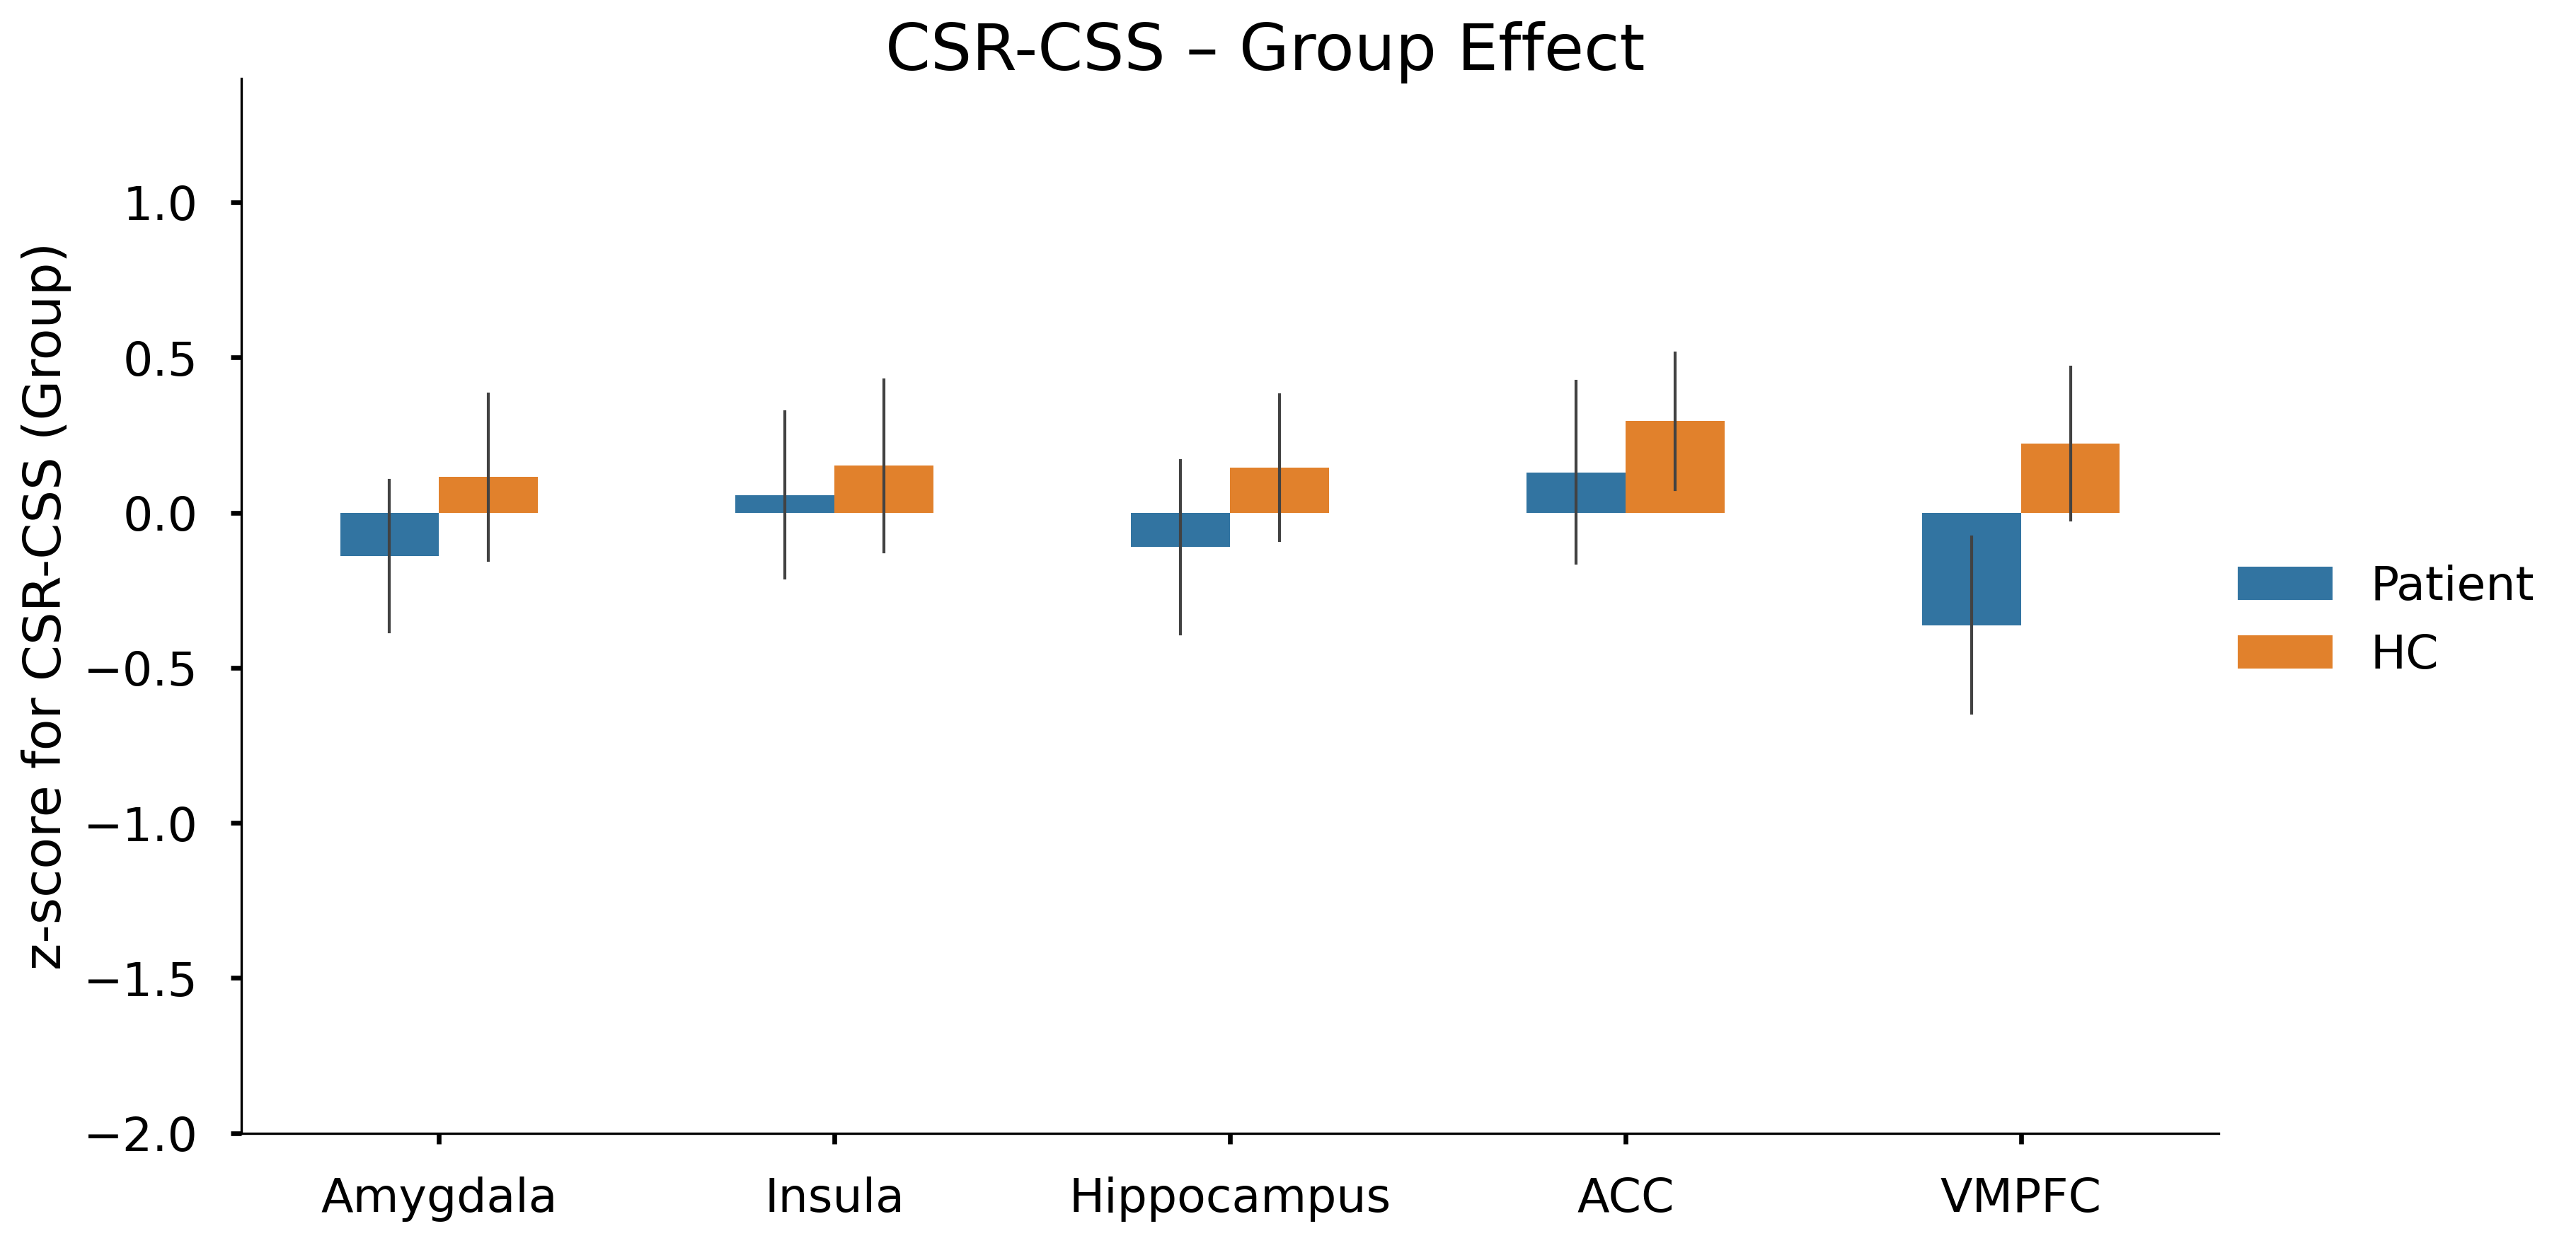


===== Group main effect: CSR-CS- =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.117     0.29    48    0.773      
Insula          Group[T.HC]                                            -0.092    -0.24    48    0.811      
Hippocampus     Group[T.HC]                                            -0.152    -0.37    48    0.710      
ACC             Group[T.HC]                                            -0.058    -0.14    48    0.887      
VMPFC           Group[T.HC]                                            -0.015    -0.04    48    0.968      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

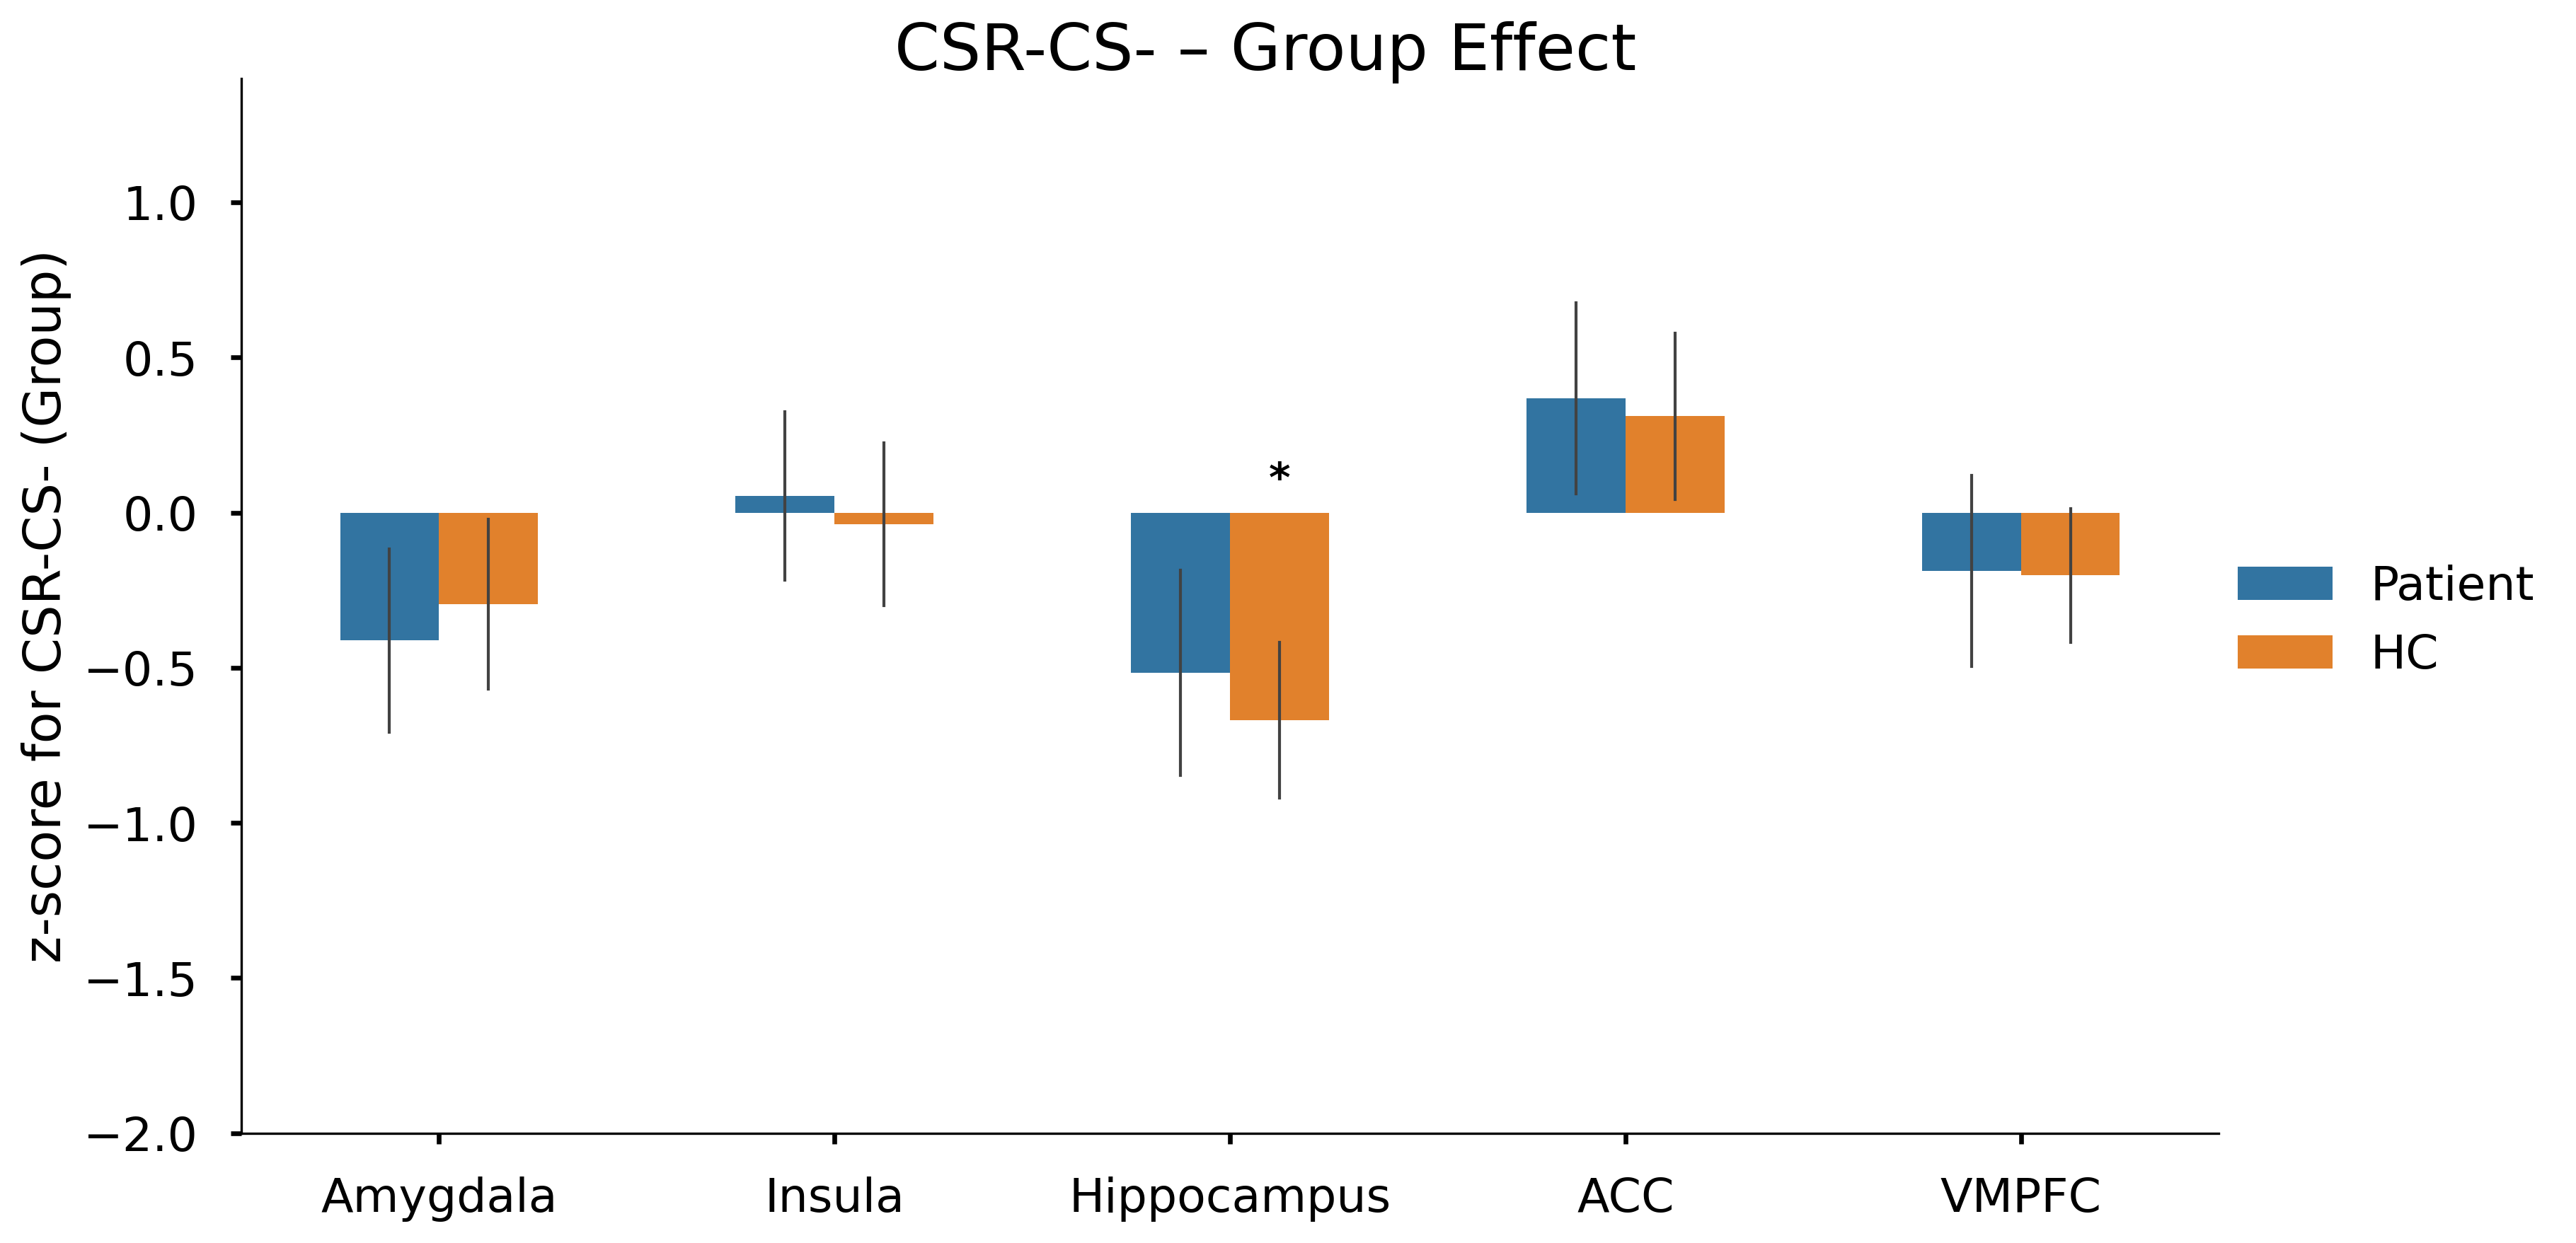


===== Group main effect: CSS-CS- =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.096    -0.26    48    0.793      
Insula          Group[T.HC]                                            -0.162    -0.45    48    0.652      
Hippocampus     Group[T.HC]                                            -0.365    -1.09    48    0.283      
ACC             Group[T.HC]                                            -0.193    -0.46    48    0.651      
VMPFC           Group[T.HC]                                            -0.555    -1.71    48    0.094      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

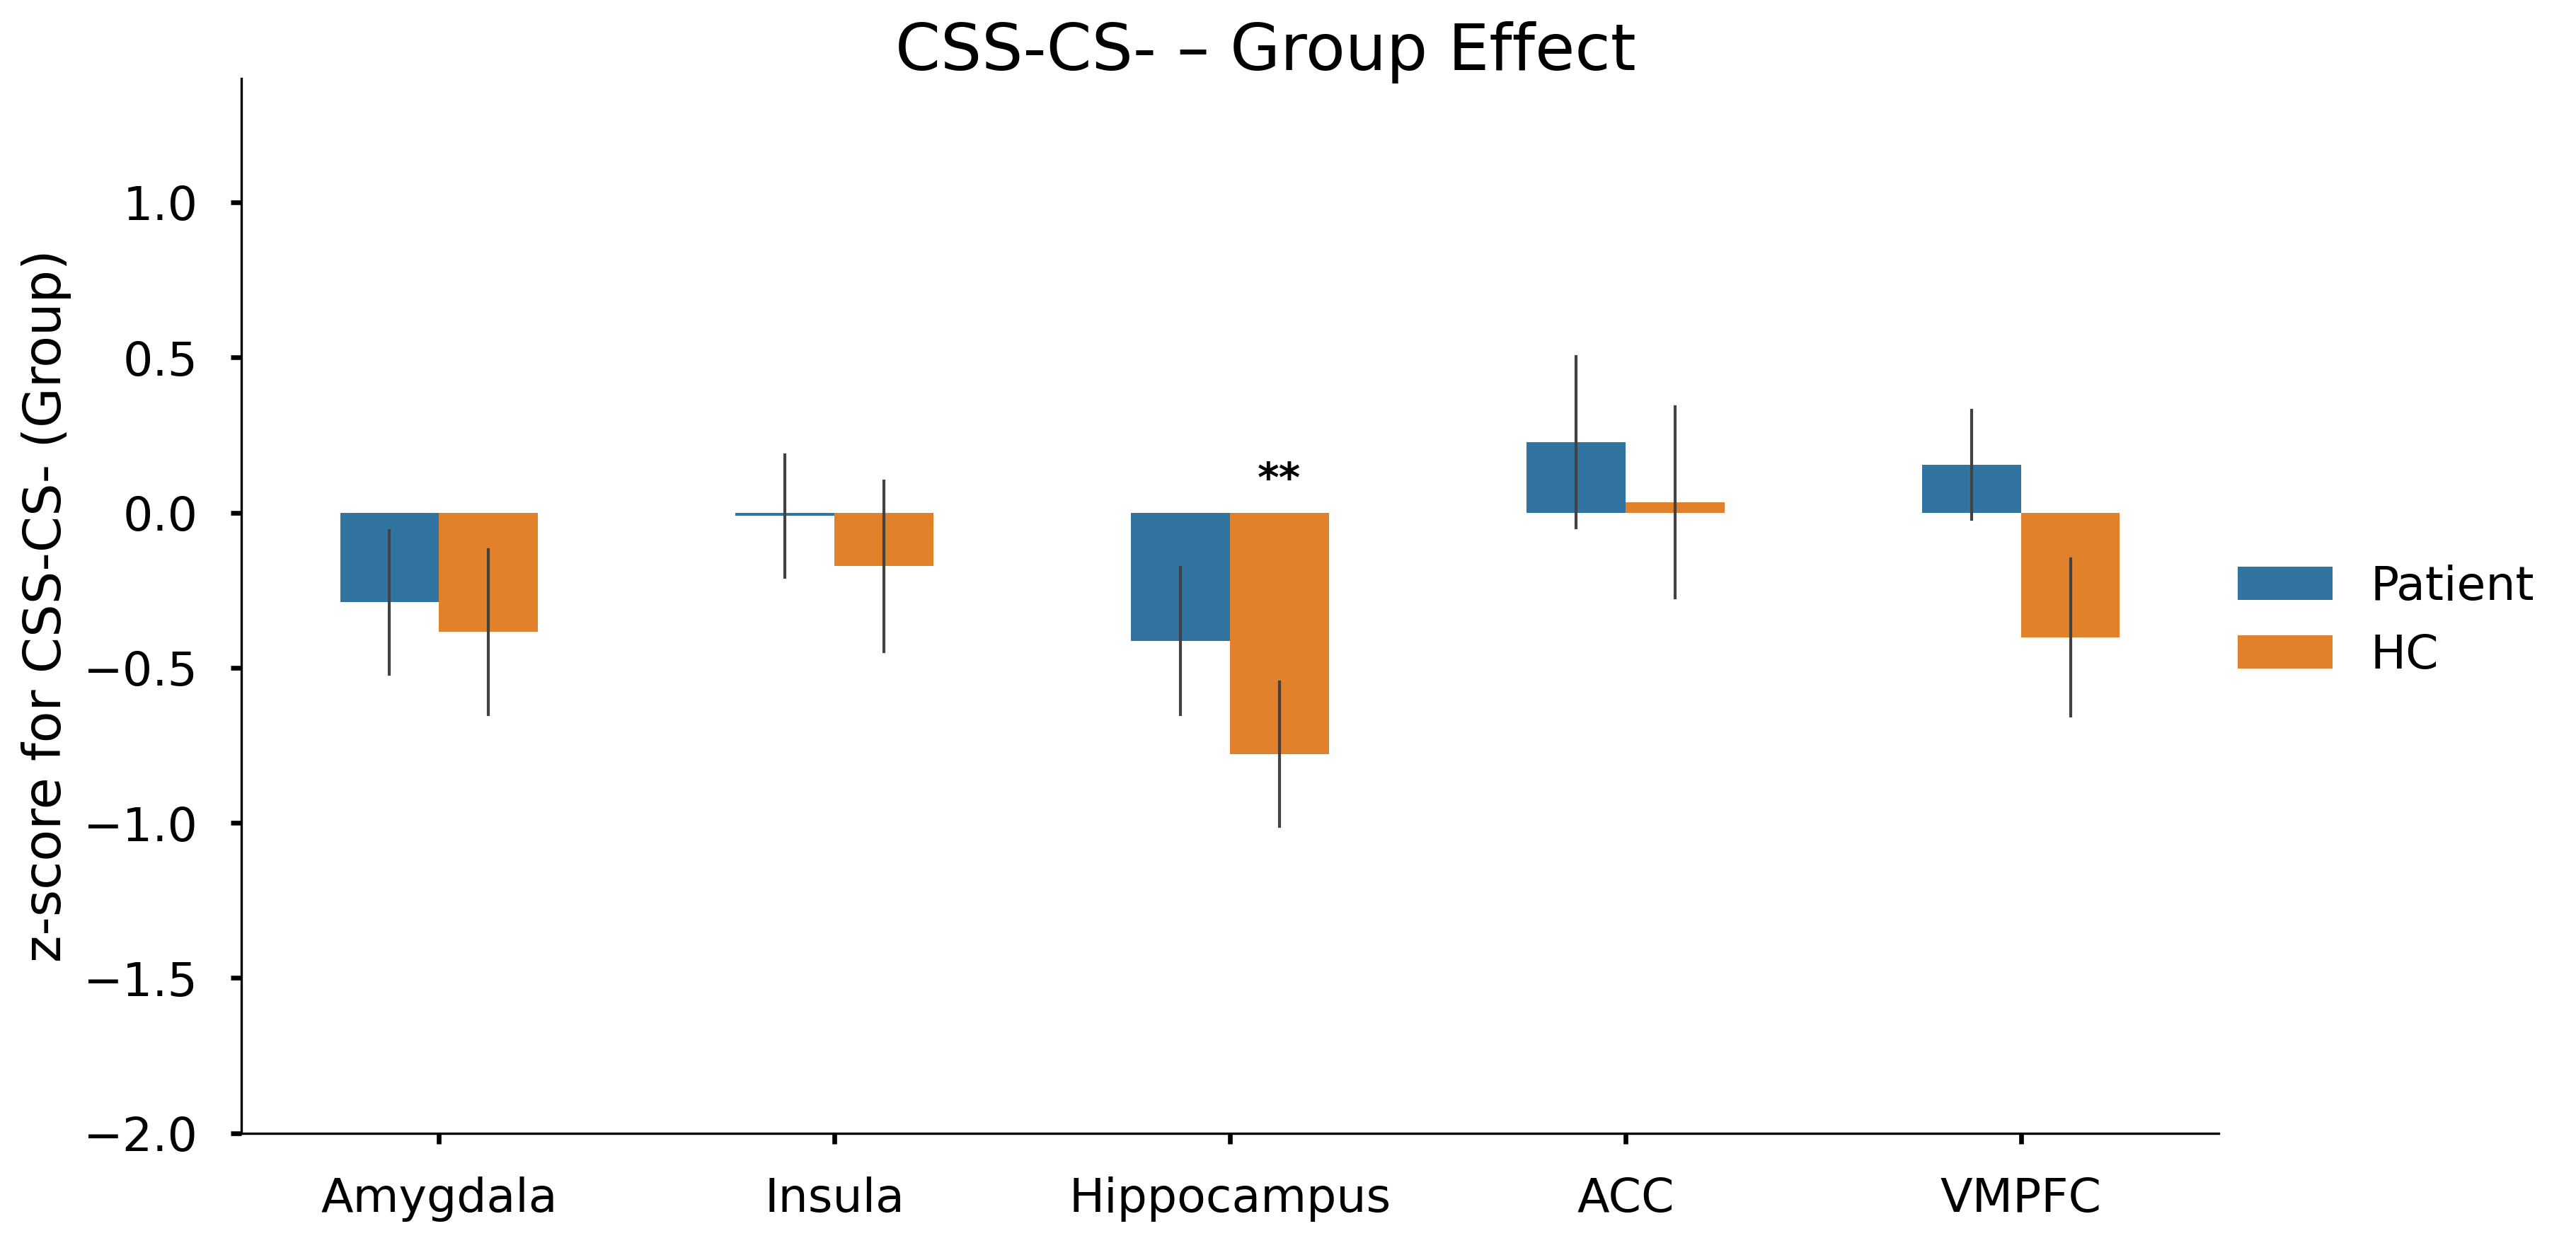


===== Group main effect: CSR-fix =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.331     0.78    48    0.442      
Insula          Group[T.HC]                                             0.090     0.21    48    0.837      
Hippocampus     Group[T.HC]                                            -0.271    -0.70    48    0.485      
ACC             Group[T.HC]                                             0.121     0.33    48    0.739      
VMPFC           Group[T.HC]                                             0.259     0.69    48    0.491      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

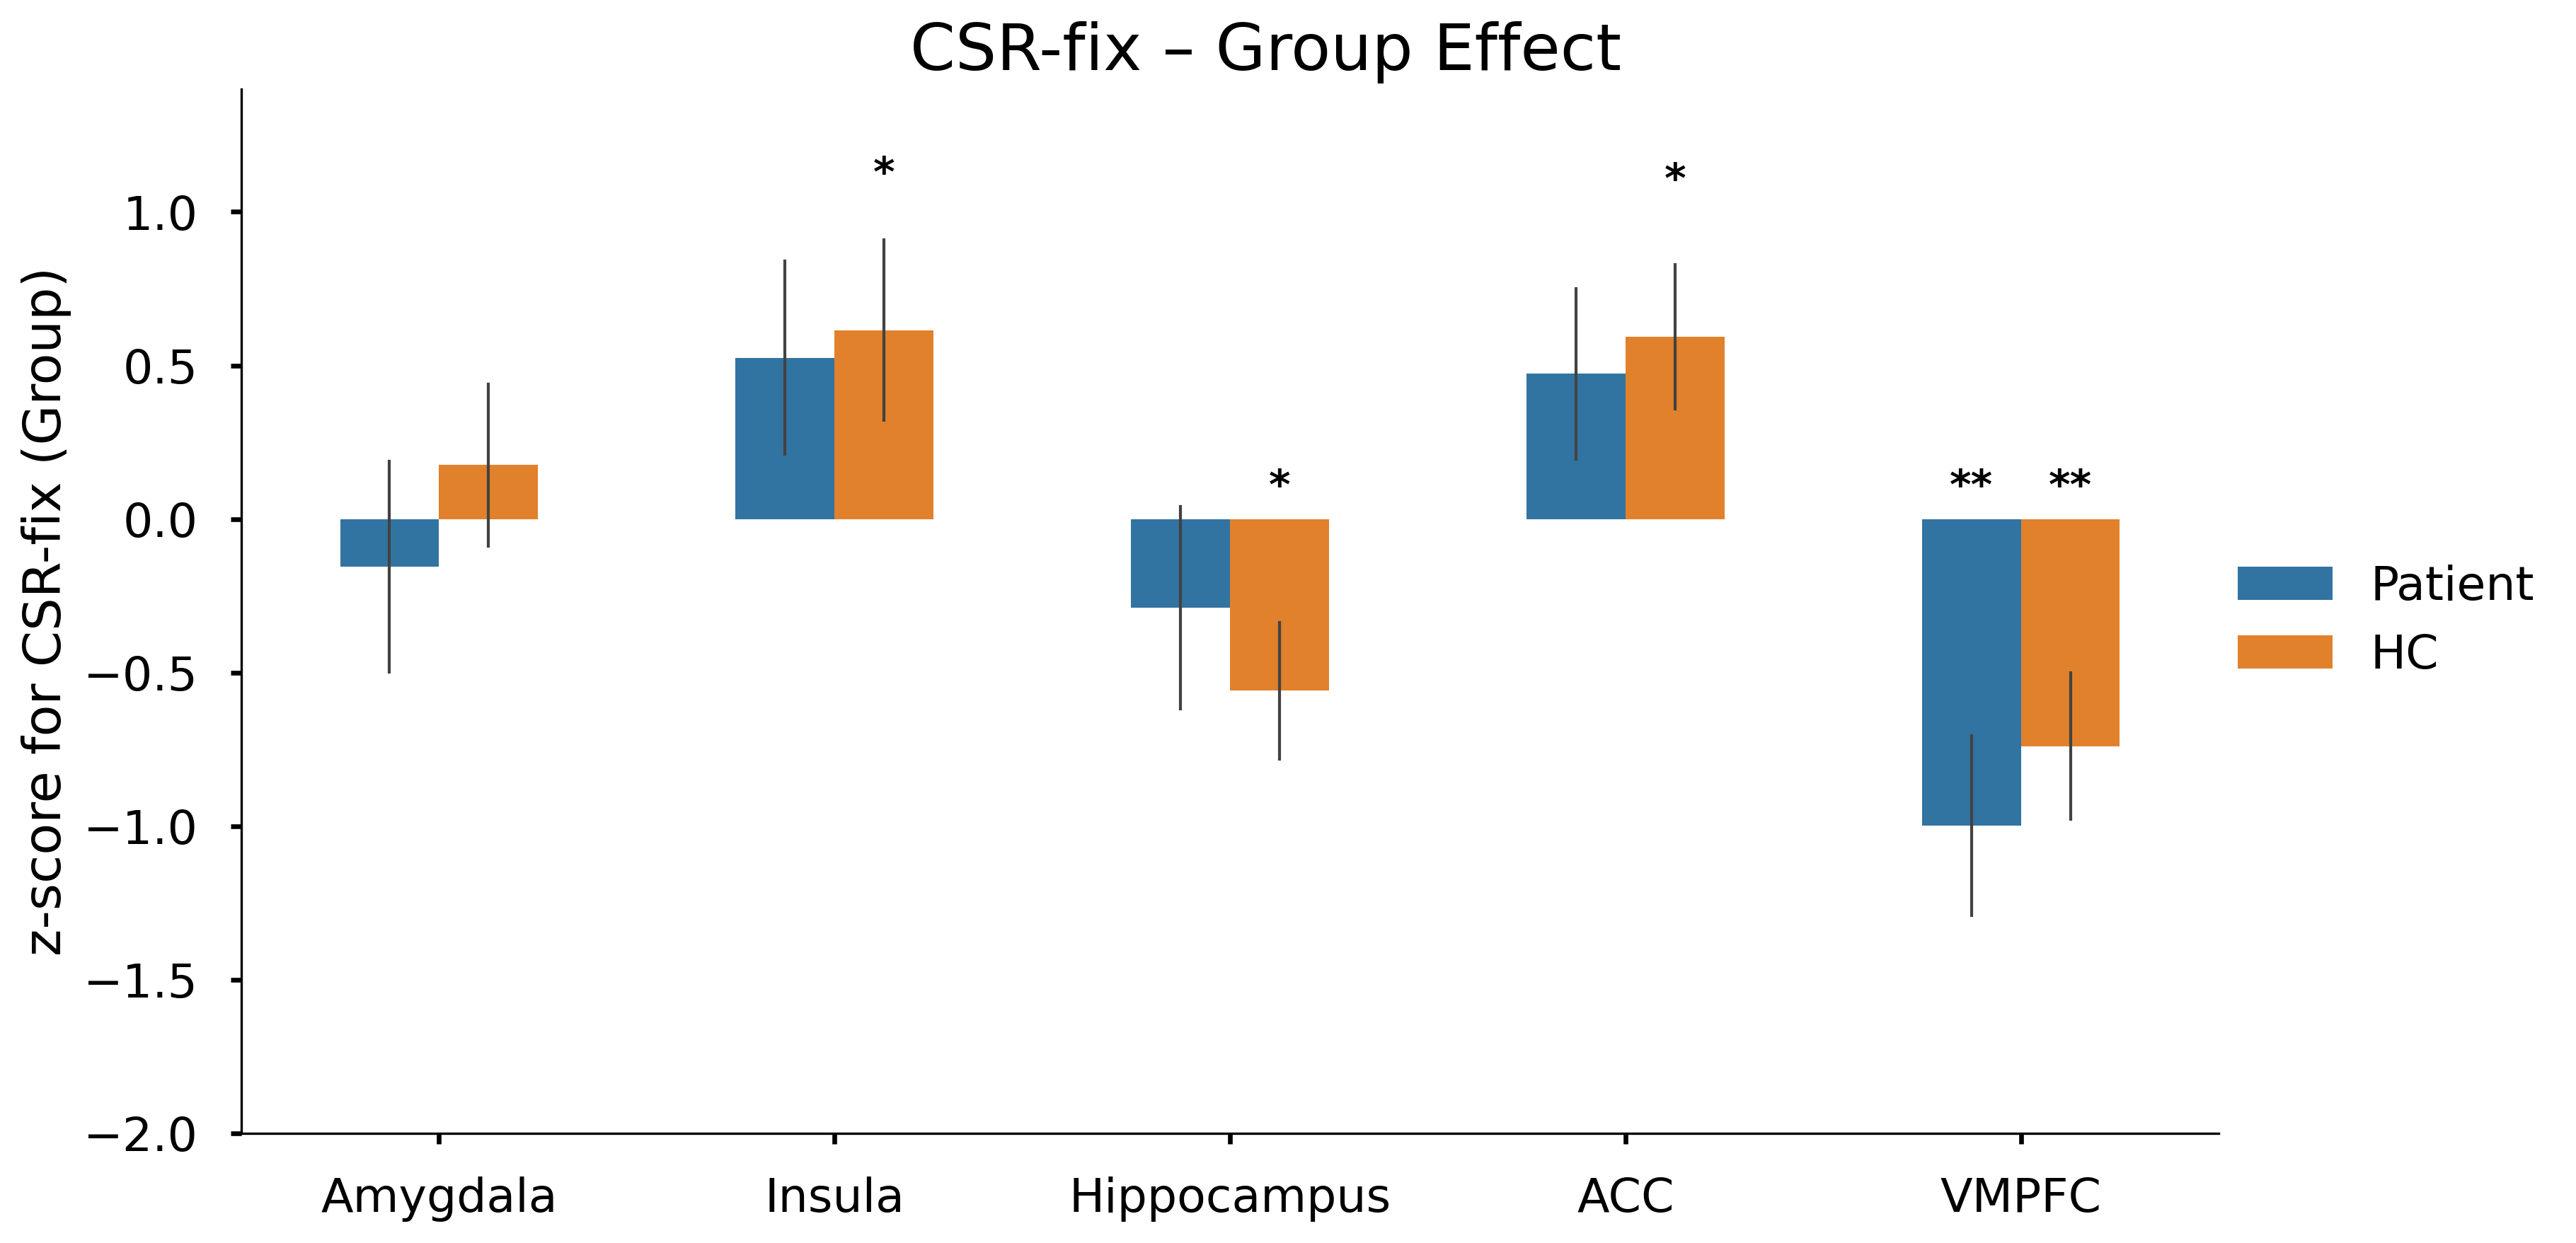


===== Group main effect: CSS-fix =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.002     0.00    48    0.996      
Insula          Group[T.HC]                                            -0.053    -0.16    48    0.874      
Hippocampus     Group[T.HC]                                            -0.600    -1.83    48    0.074      
ACC             Group[T.HC]                                            -0.109    -0.26    48    0.794      
VMPFC           Group[T.HC]                                            -0.497    -1.20    48    0.237      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                      

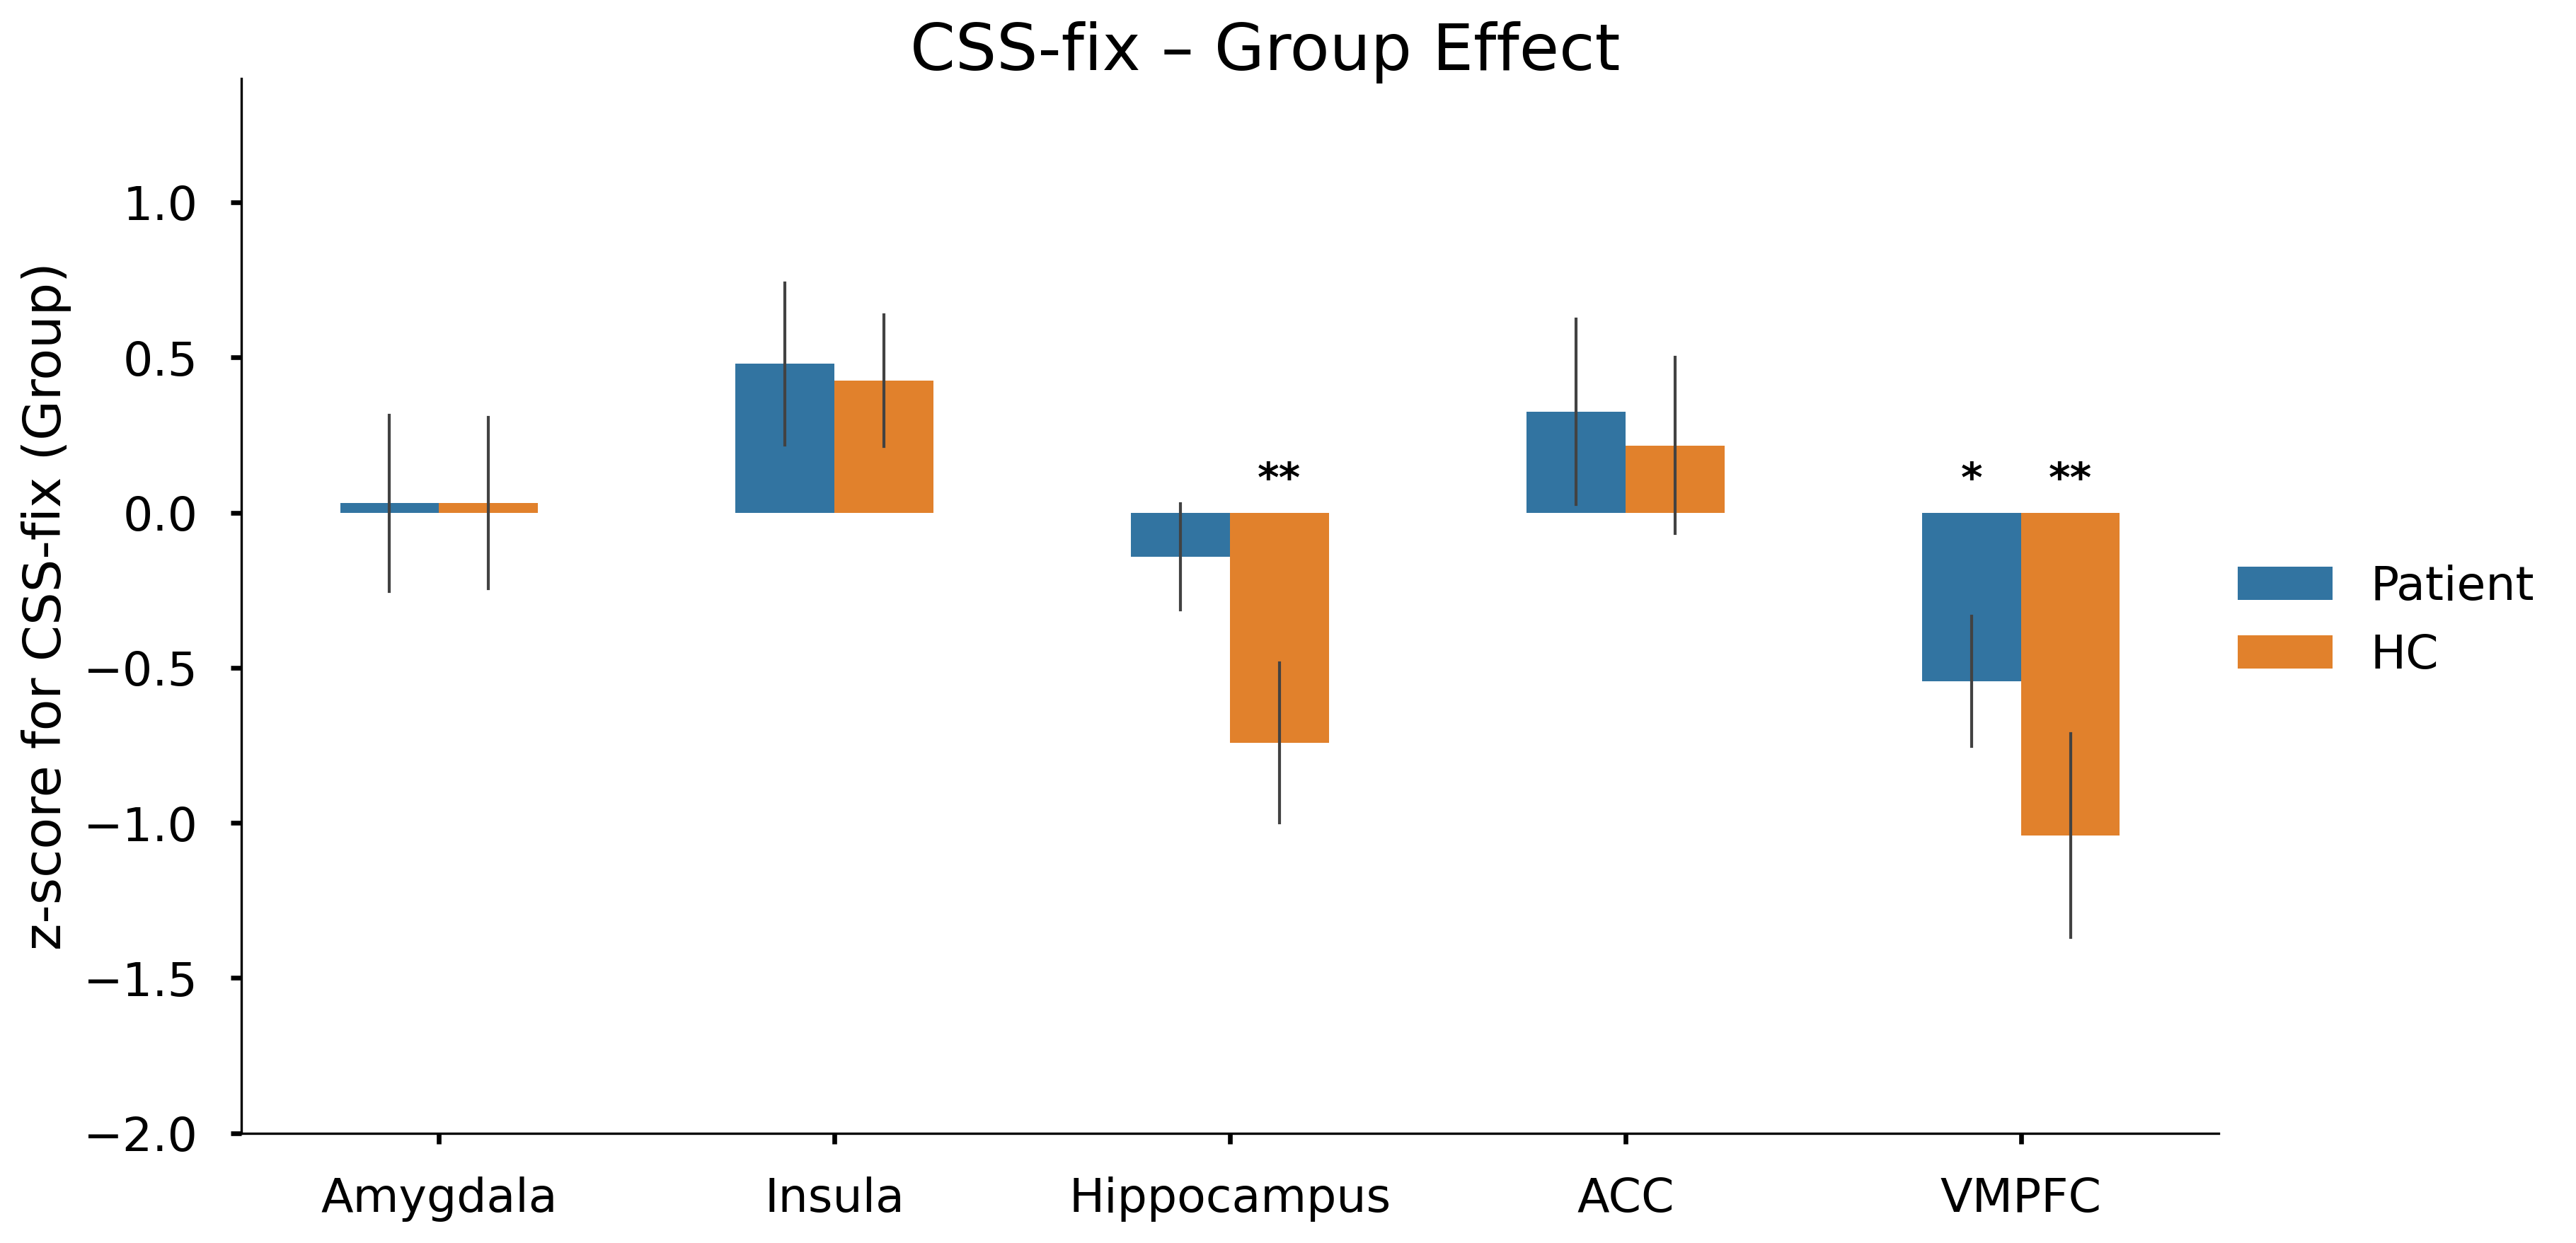


===== Group main effect: CSminus-fix =====

Model results (Z_score ~ Group)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.132     0.35    48    0.724      
Insula          Group[T.HC]                                             0.155     0.40    48    0.689      
Hippocampus     Group[T.HC]                                            -0.089    -0.25    48    0.801      
ACC             Group[T.HC]                                             0.142     0.36    48    0.719      
VMPFC           Group[T.HC]                                             0.257     0.79    48    0.435      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level                  

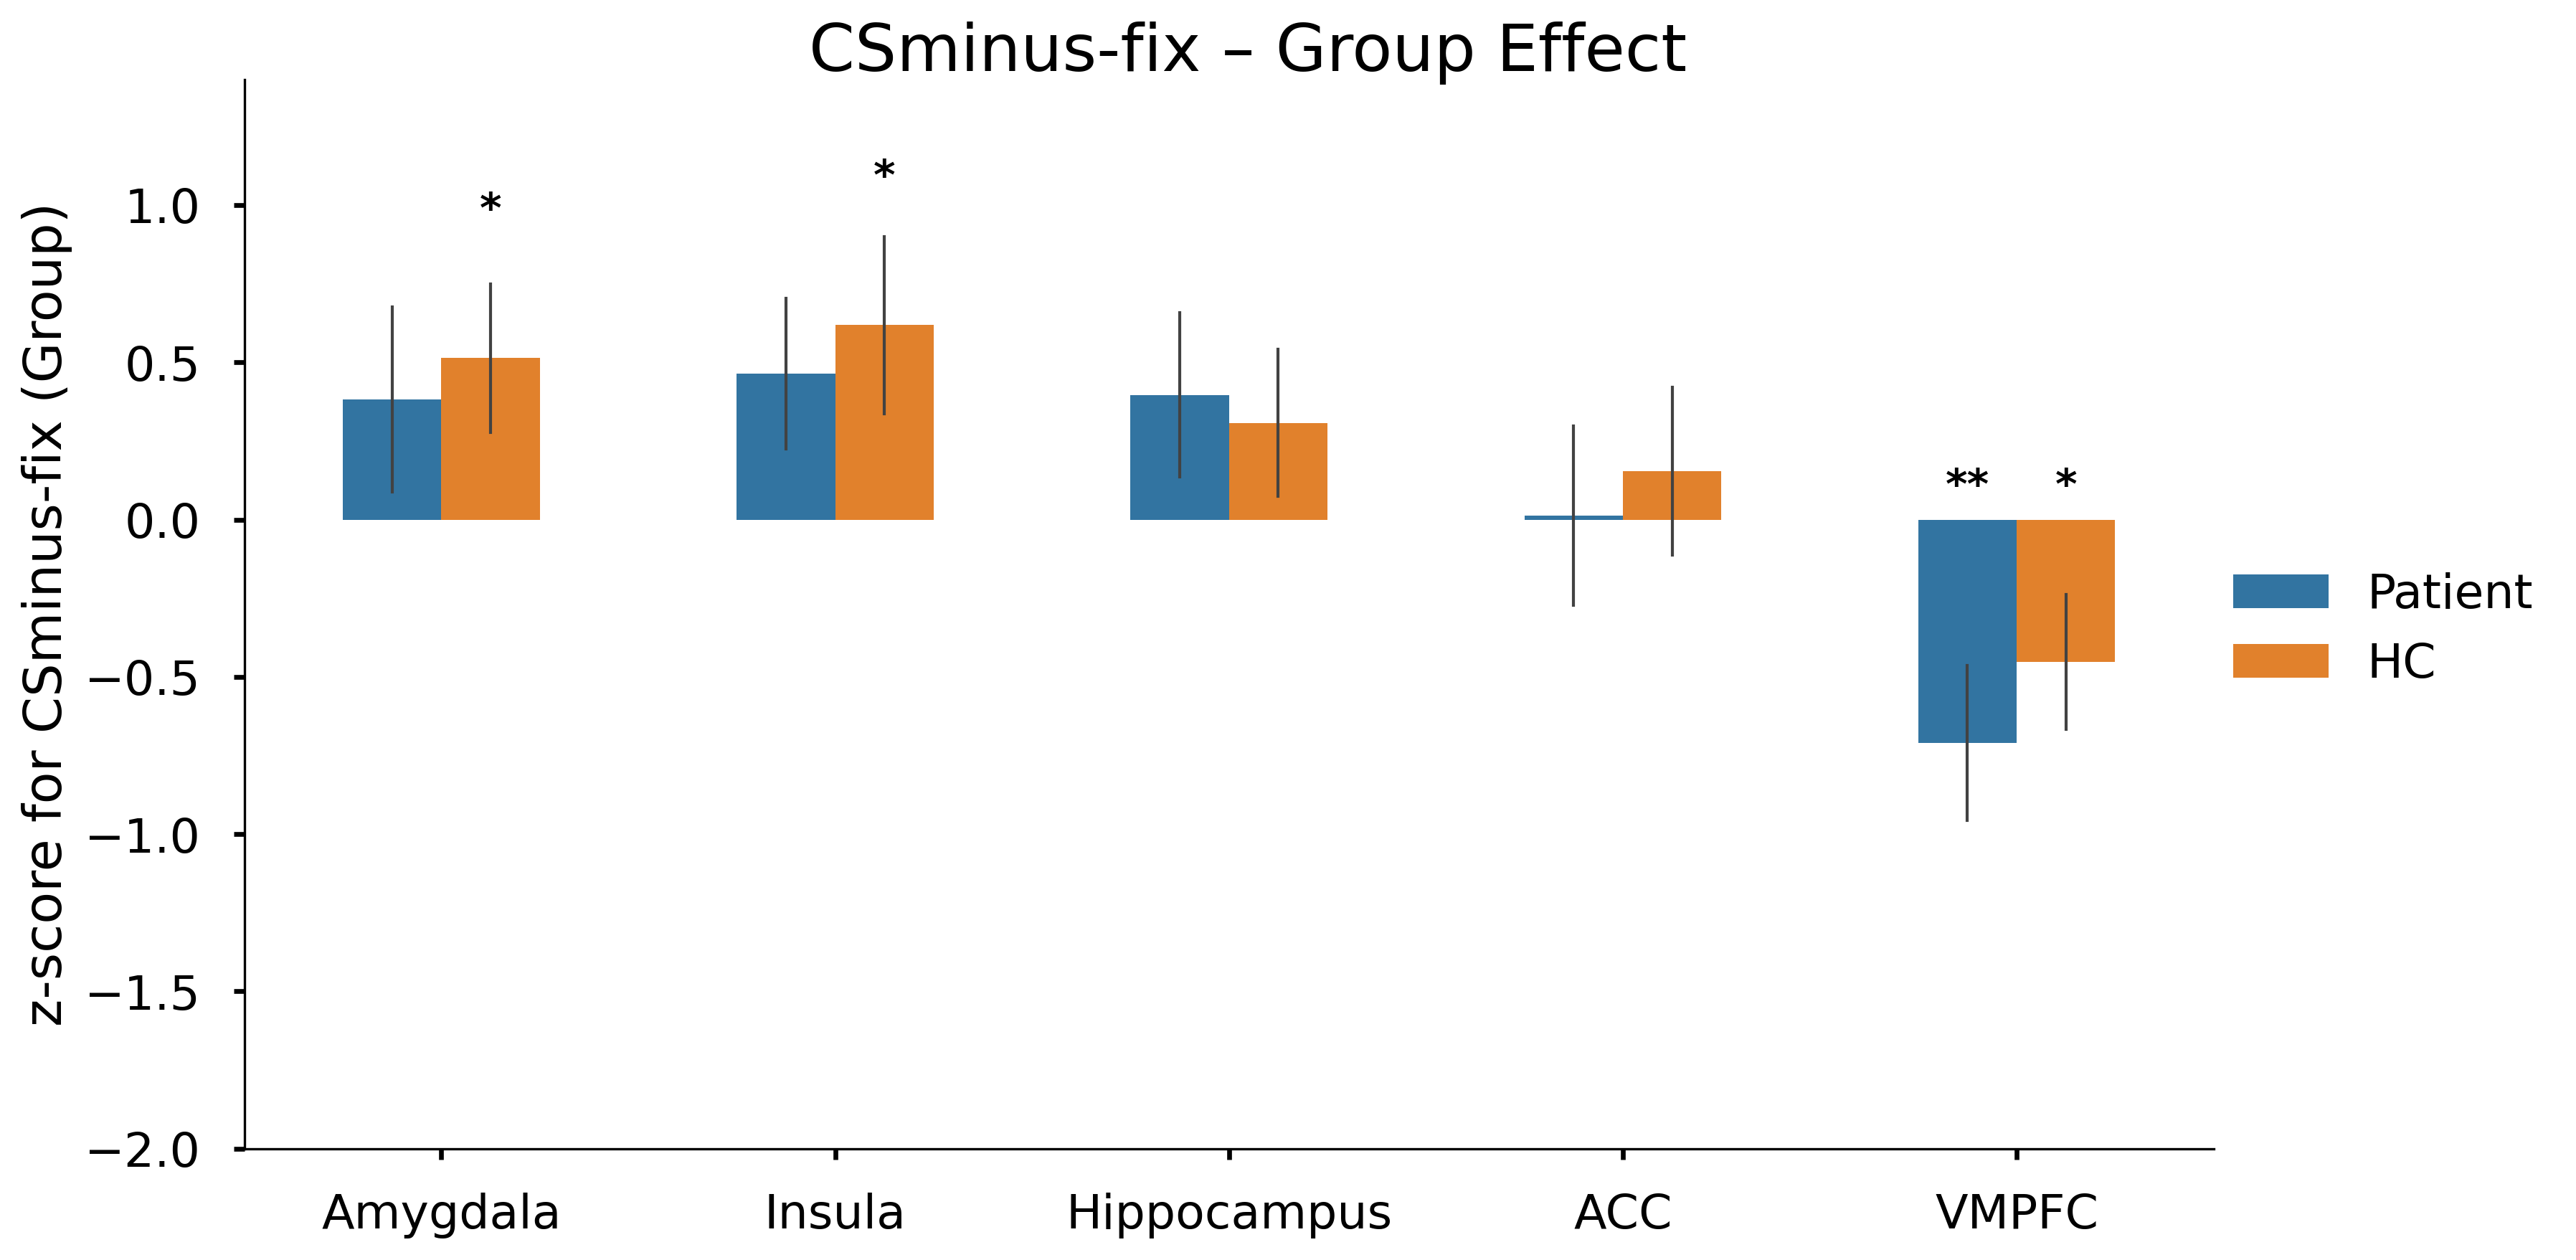

In [10]:
# 1️⃣ Group main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Group main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase3')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Group',
        order=ROI_list, hue_order=group_list,
        kind='bar', errorbar='se', 
        height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Group")[0], hue_order=group_list)


    g.set_axis_labels('', f'z-score for {contrast} (Group)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Group Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Group_sig.png', bbox_inches='tight')
    plt.show()


===== Gender main effect: CSR-CSS =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.330    -1.36    99    0.178      
Insula          Gender[T.Female]                                        0.012     0.04    99    0.965      
Hippocampus     Gender[T.Female]                                       -0.297    -1.18    99    0.242      
ACC             Gender[T.Female]                                       -0.053    -0.20    99    0.841      
VMPFC           Gender[T.Female]                                        0.056     0.23    99    0.822      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

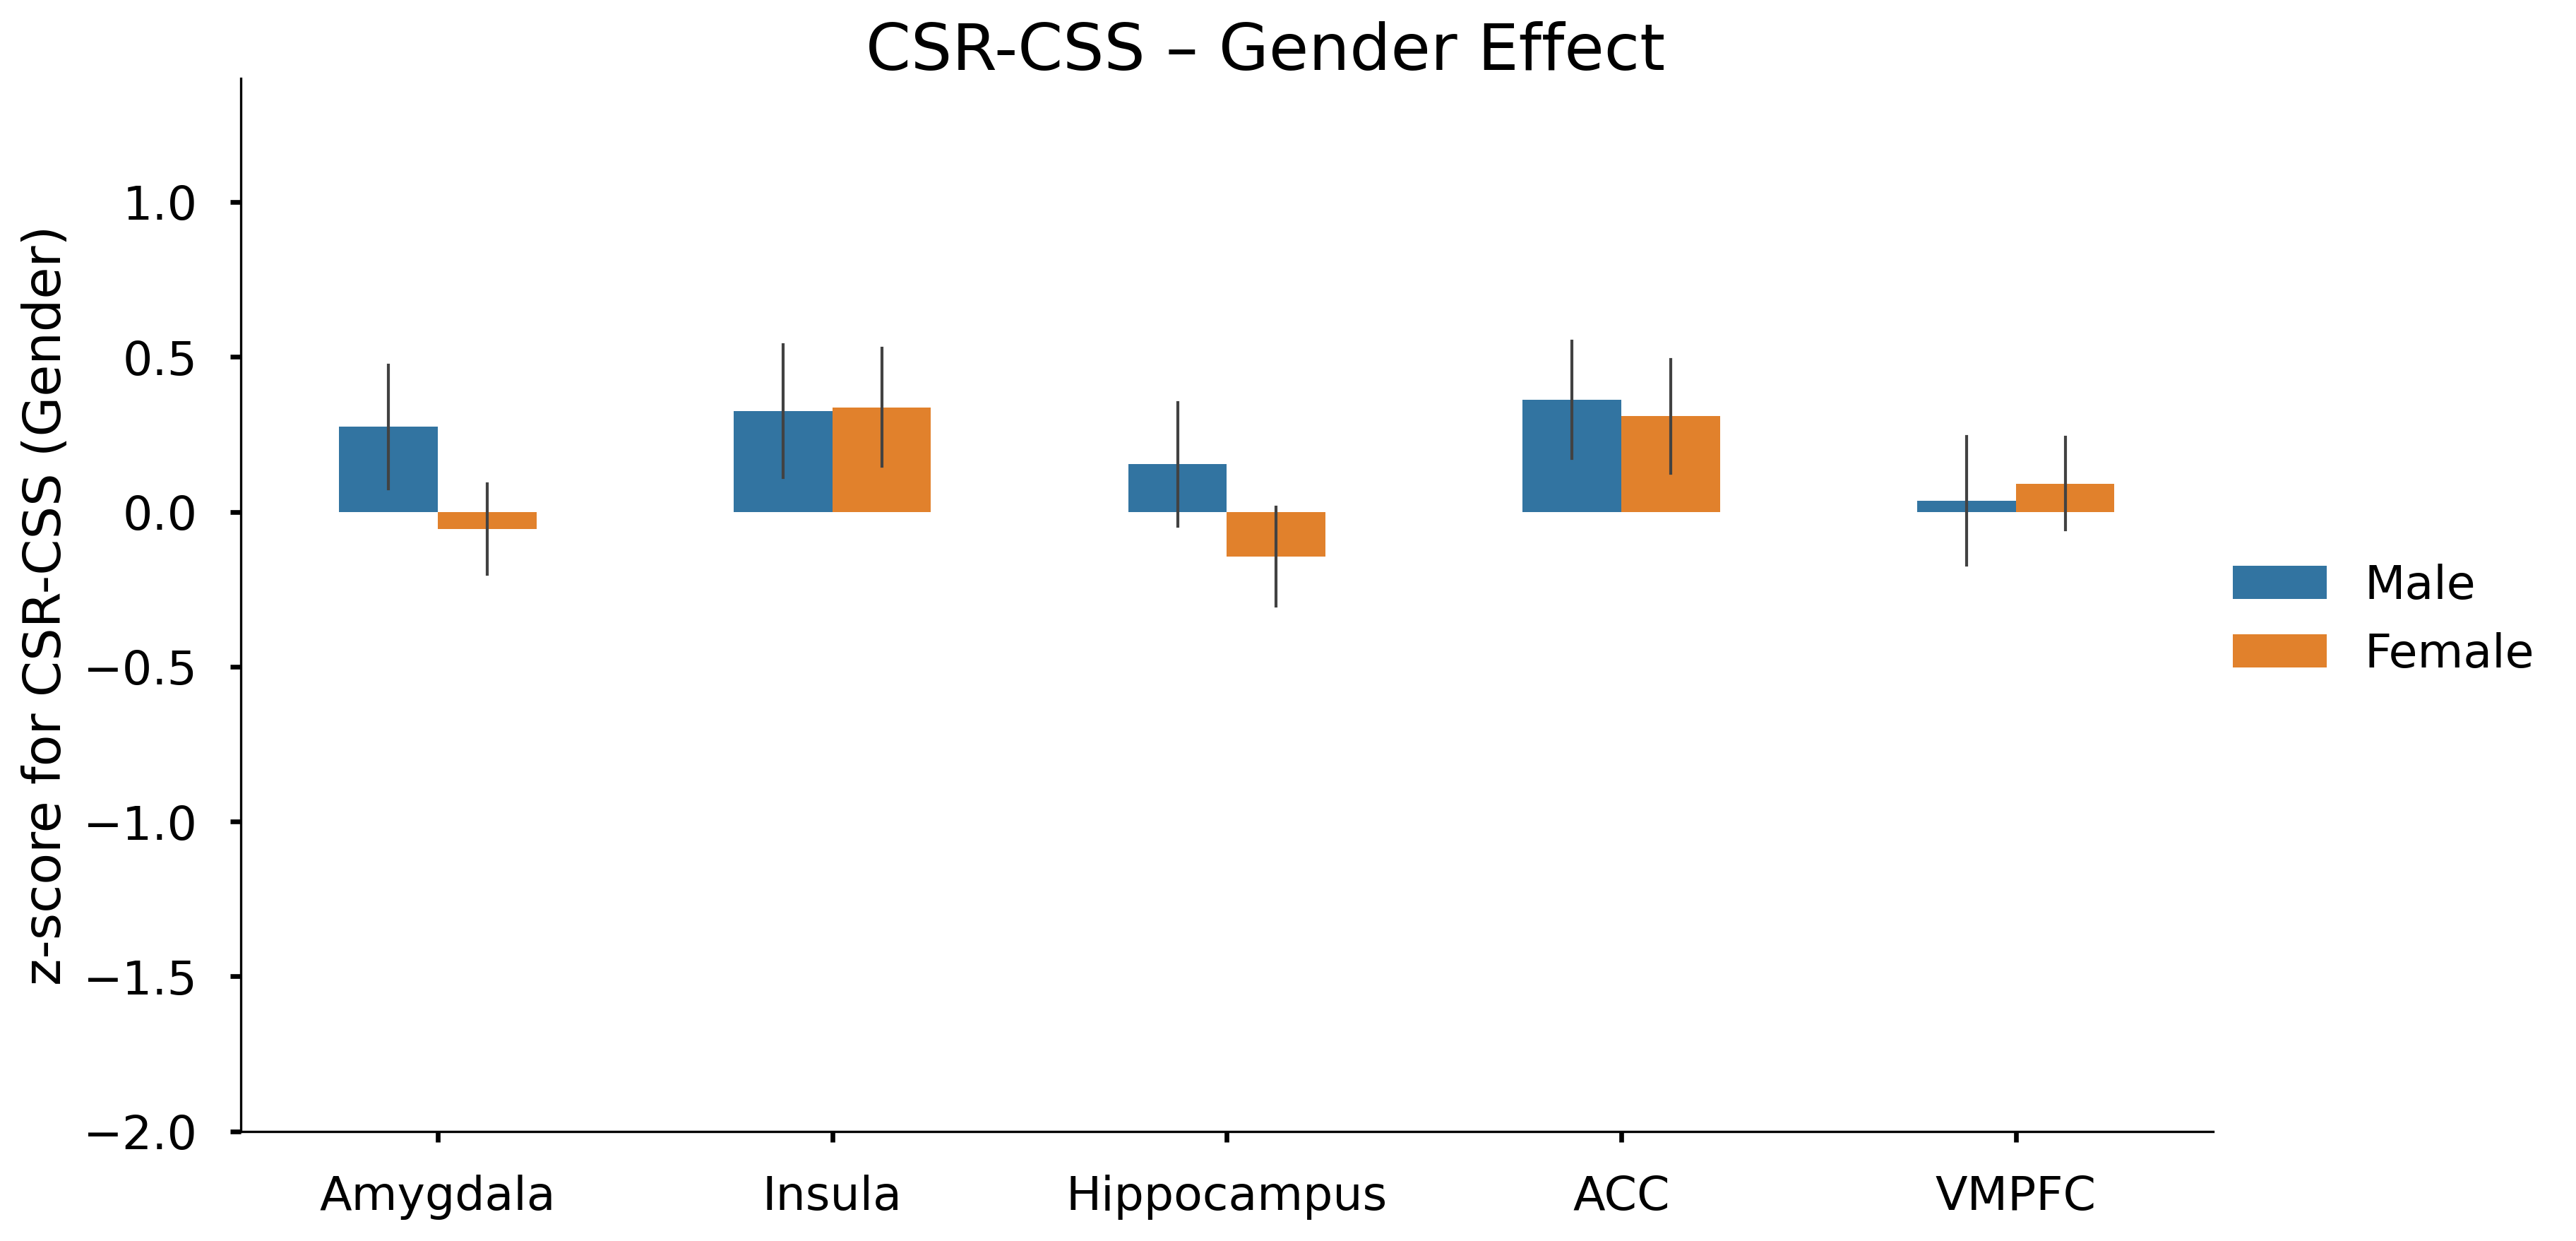


===== Gender main effect: CSR-CS- =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.432    -1.62    99    0.109      
Insula          Gender[T.Female]                                       -0.077    -0.27    99    0.788      
Hippocampus     Gender[T.Female]                                       -0.344    -1.28    99    0.203      
ACC             Gender[T.Female]                                       -0.001    -0.00    99    0.997      
VMPFC           Gender[T.Female]                                        0.272     1.04    99    0.303      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

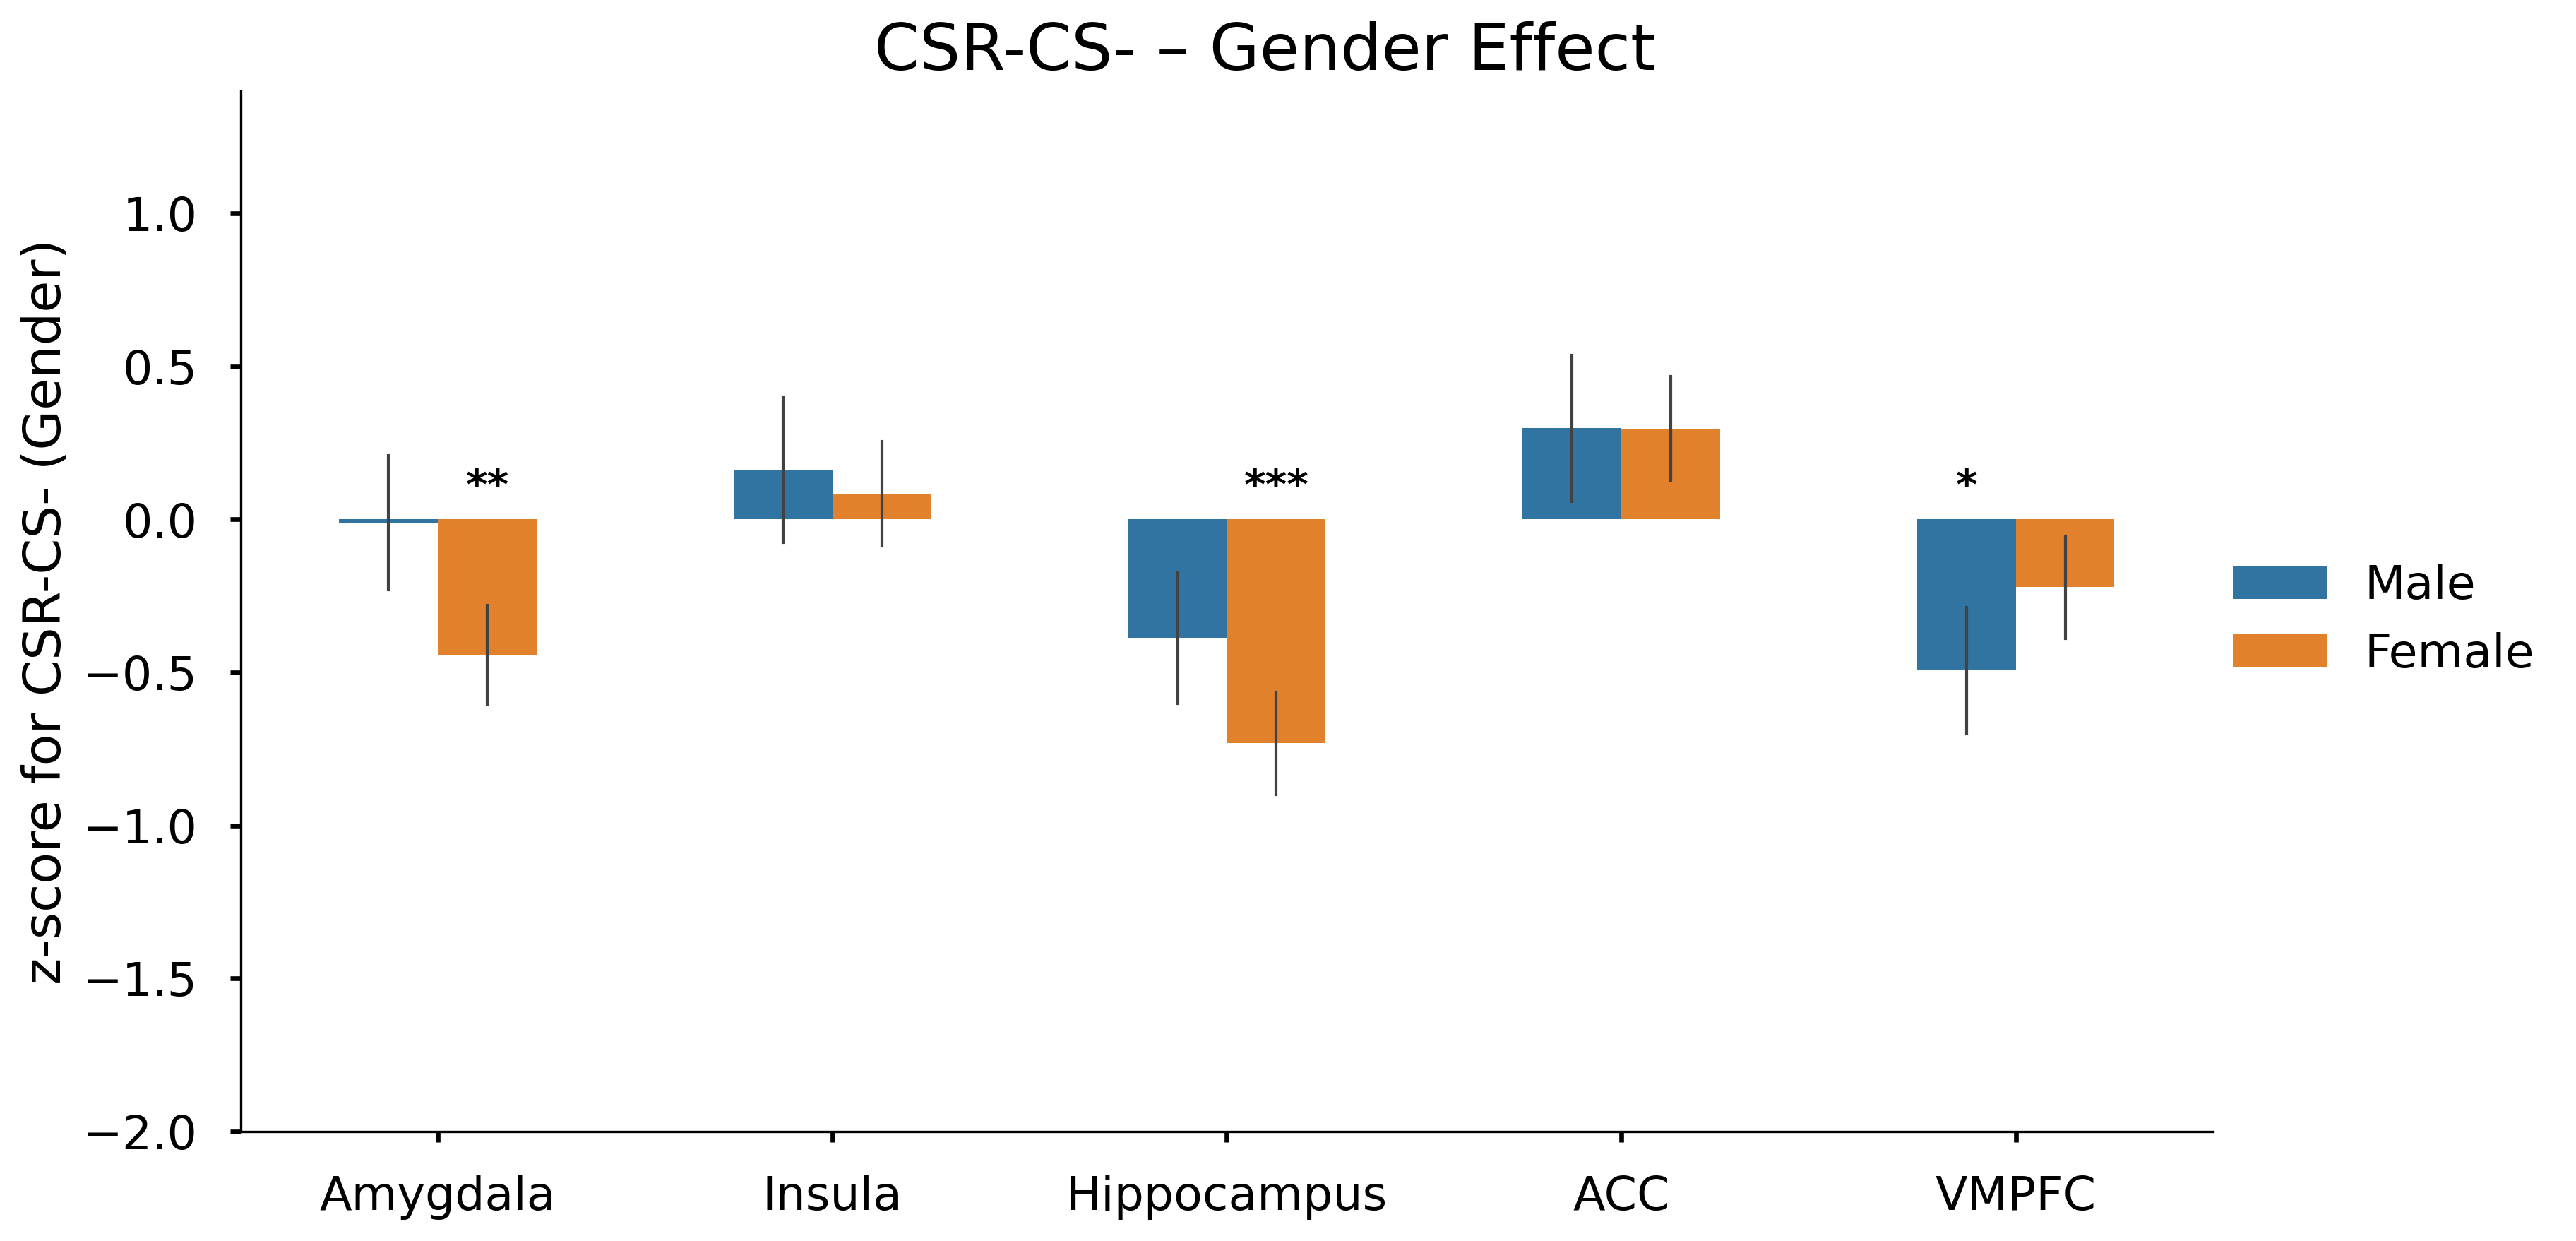


===== Gender main effect: CSS-CS- =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.108    -0.43    99    0.671      
Insula          Gender[T.Female]                                       -0.083    -0.33    99    0.743      
Hippocampus     Gender[T.Female]                                       -0.060    -0.24    99    0.813      
ACC             Gender[T.Female]                                        0.046     0.17    99    0.863      
VMPFC           Gender[T.Female]                                        0.212     0.85    99    0.396      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

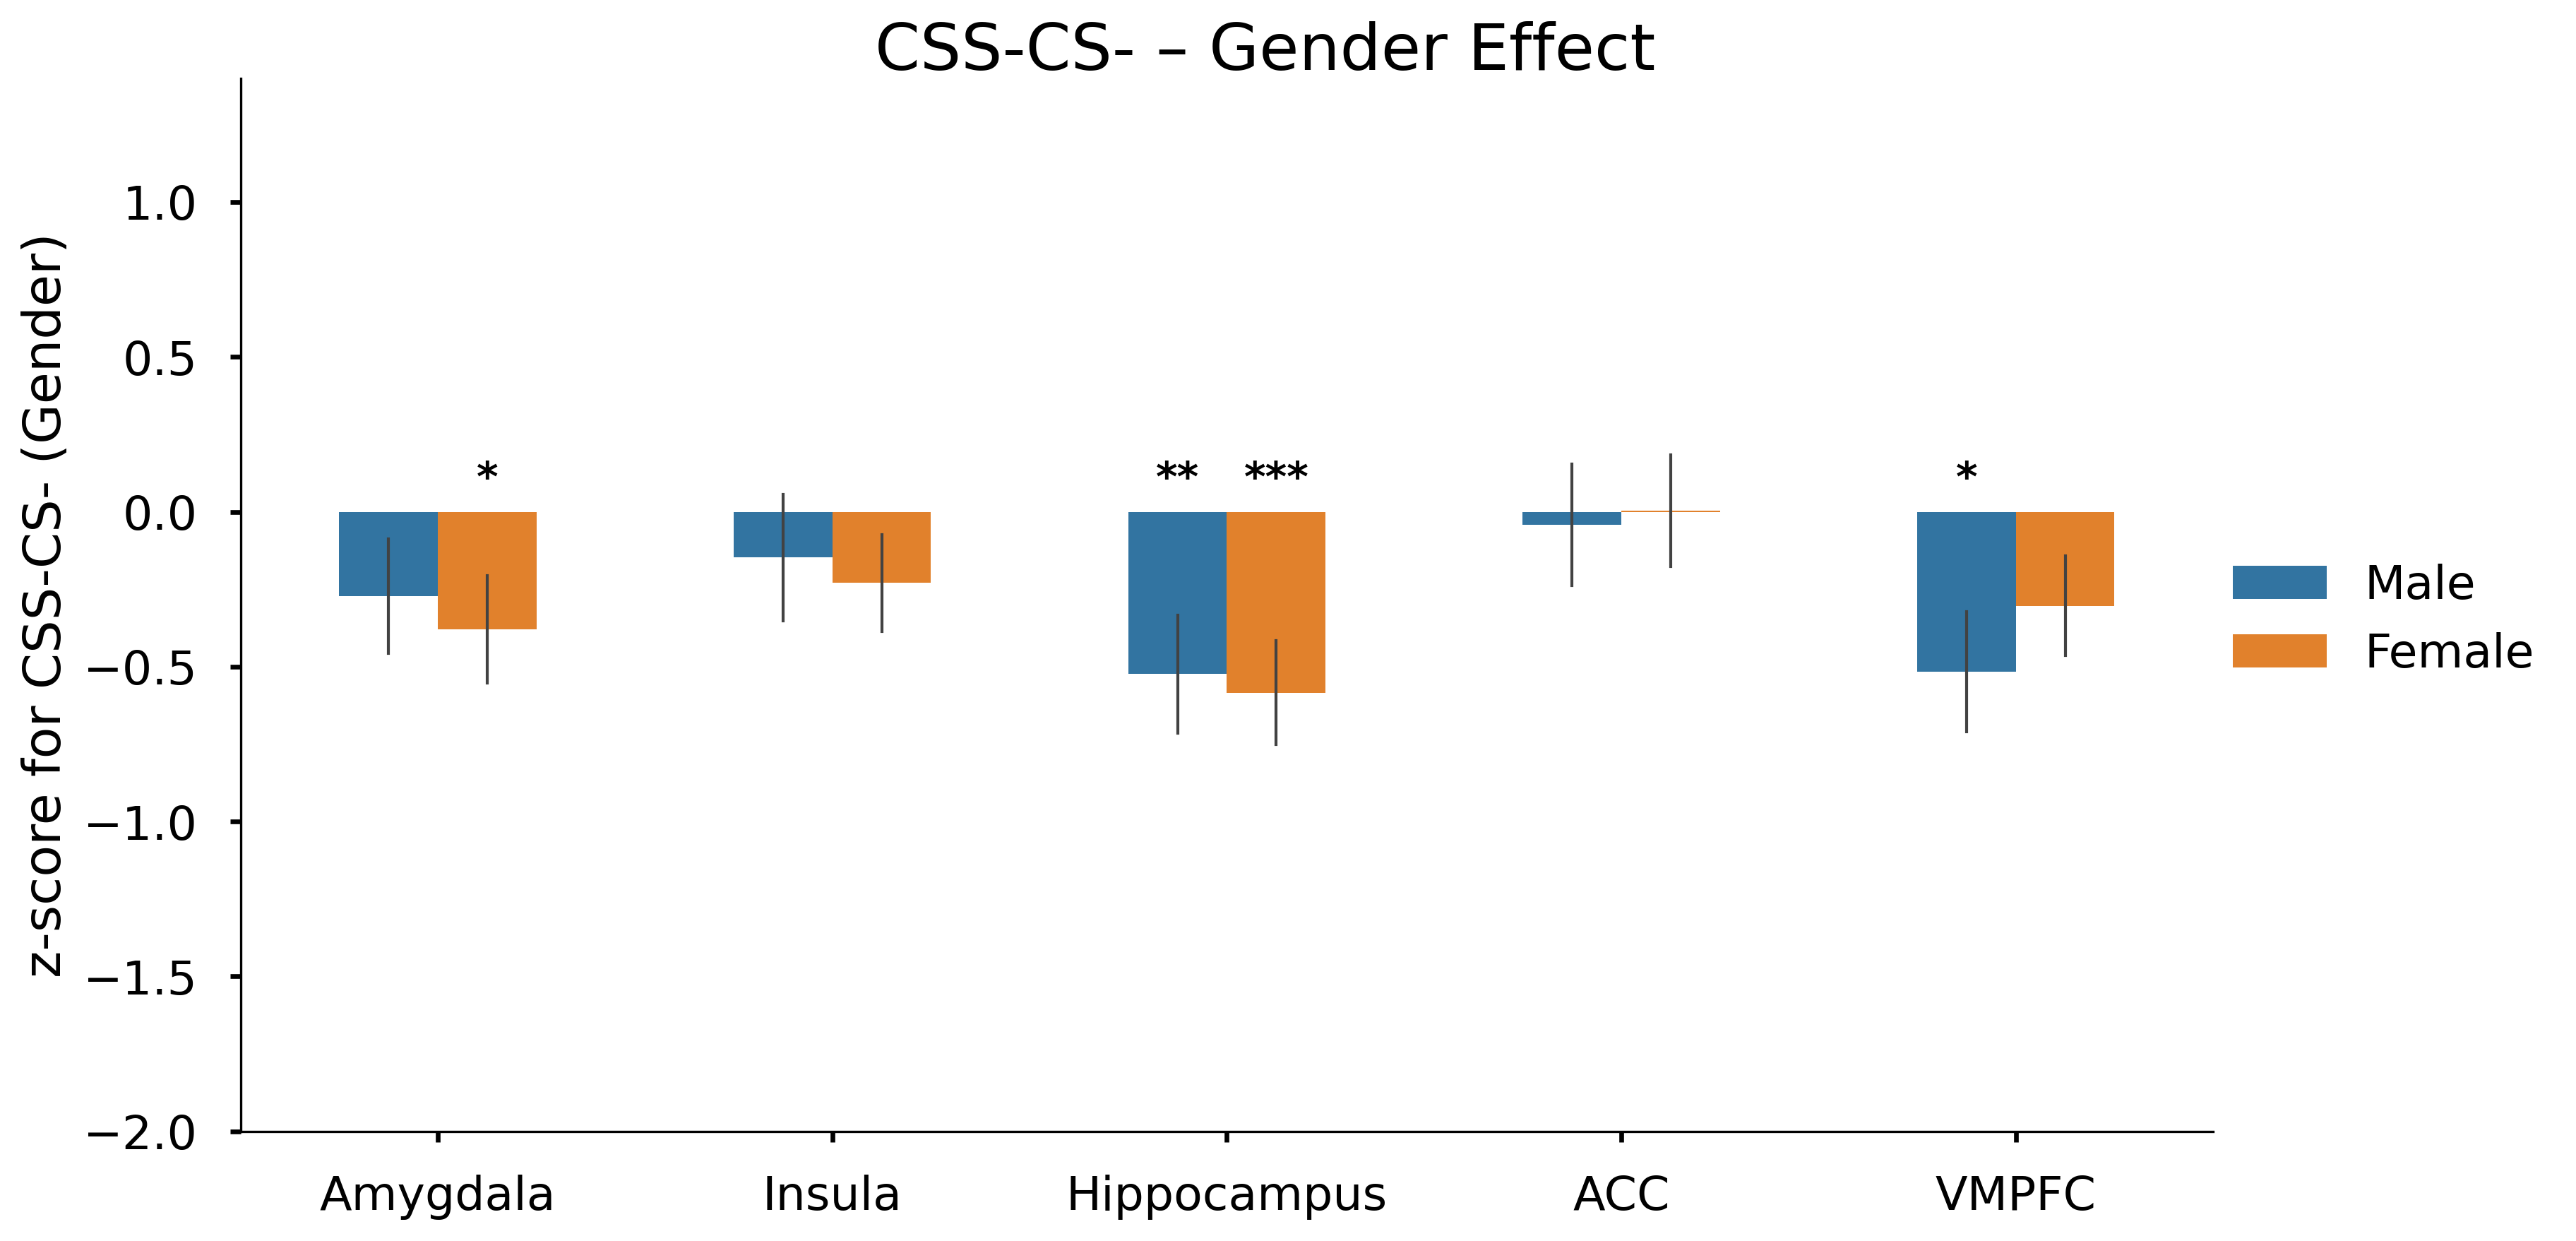


===== Gender main effect: CSR-fix =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.301    -0.97    99    0.332      
Insula          Gender[T.Female]                                       -0.168    -0.52    99    0.607      
Hippocampus     Gender[T.Female]                                       -0.245    -0.89    99    0.374      
ACC             Gender[T.Female]                                       -0.537    -1.84    99    0.069      
VMPFC           Gender[T.Female]                                       -0.006    -0.02    99    0.981      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

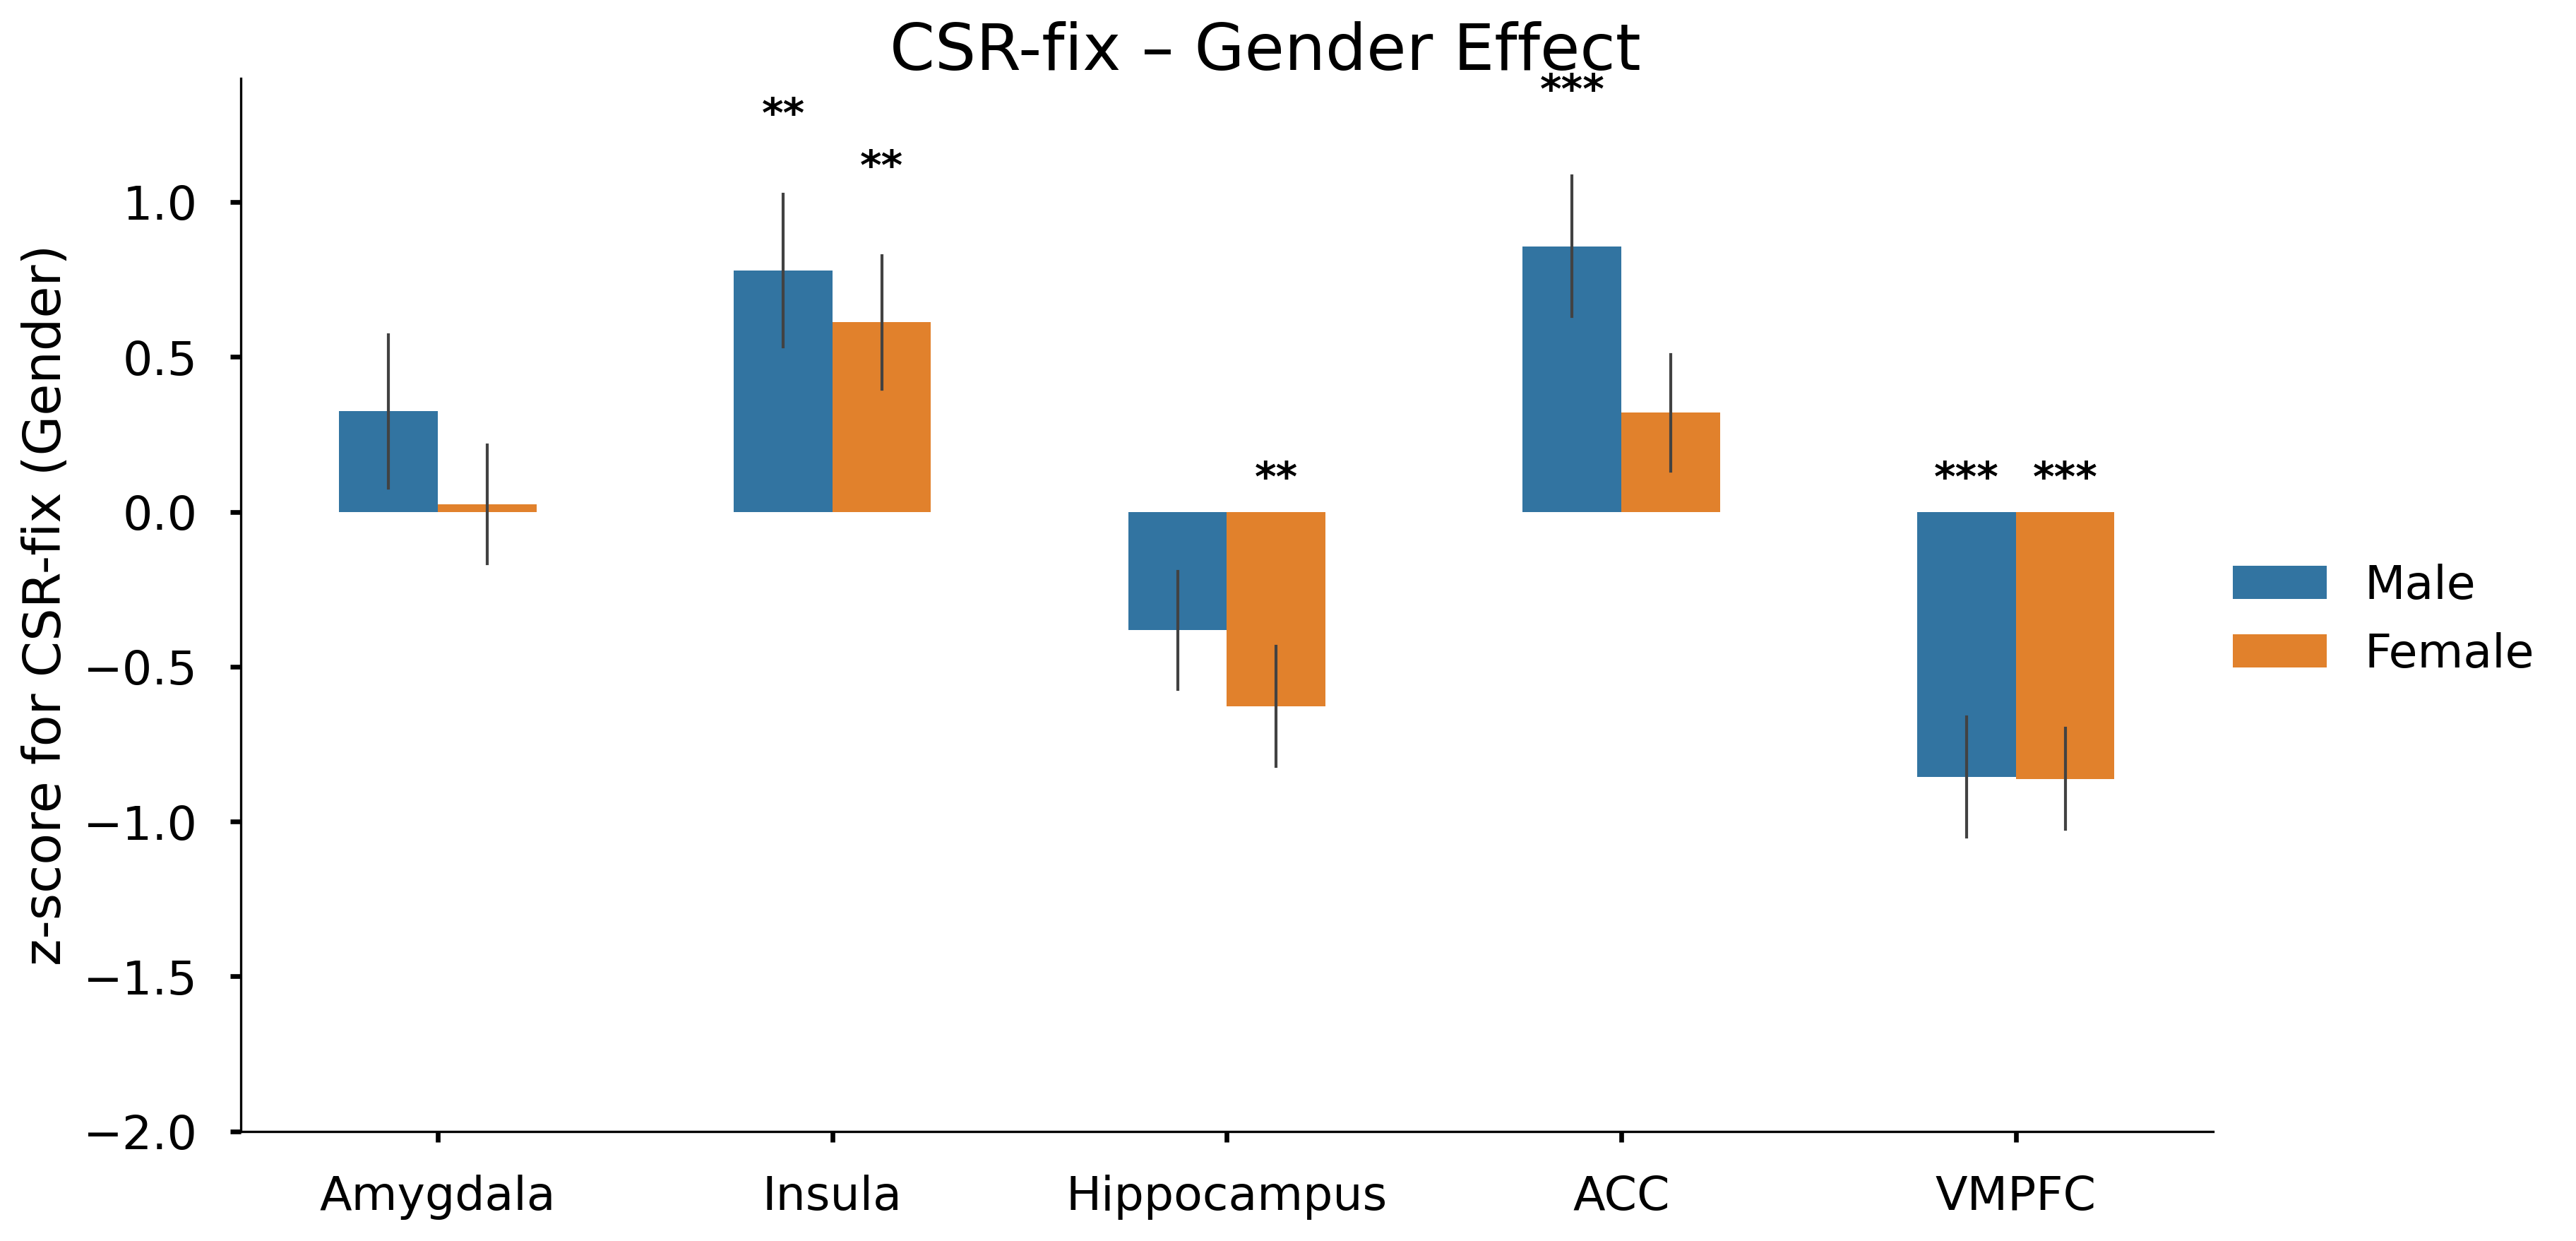


===== Gender main effect: CSS-fix =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.115     0.40    99    0.690      
Insula          Gender[T.Female]                                       -0.195    -0.79    99    0.429      
Hippocampus     Gender[T.Female]                                        0.129     0.46    99    0.646      
ACC             Gender[T.Female]                                       -0.485    -1.77    99    0.080      
VMPFC           Gender[T.Female]                                       -0.077    -0.28    99    0.781      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level                   

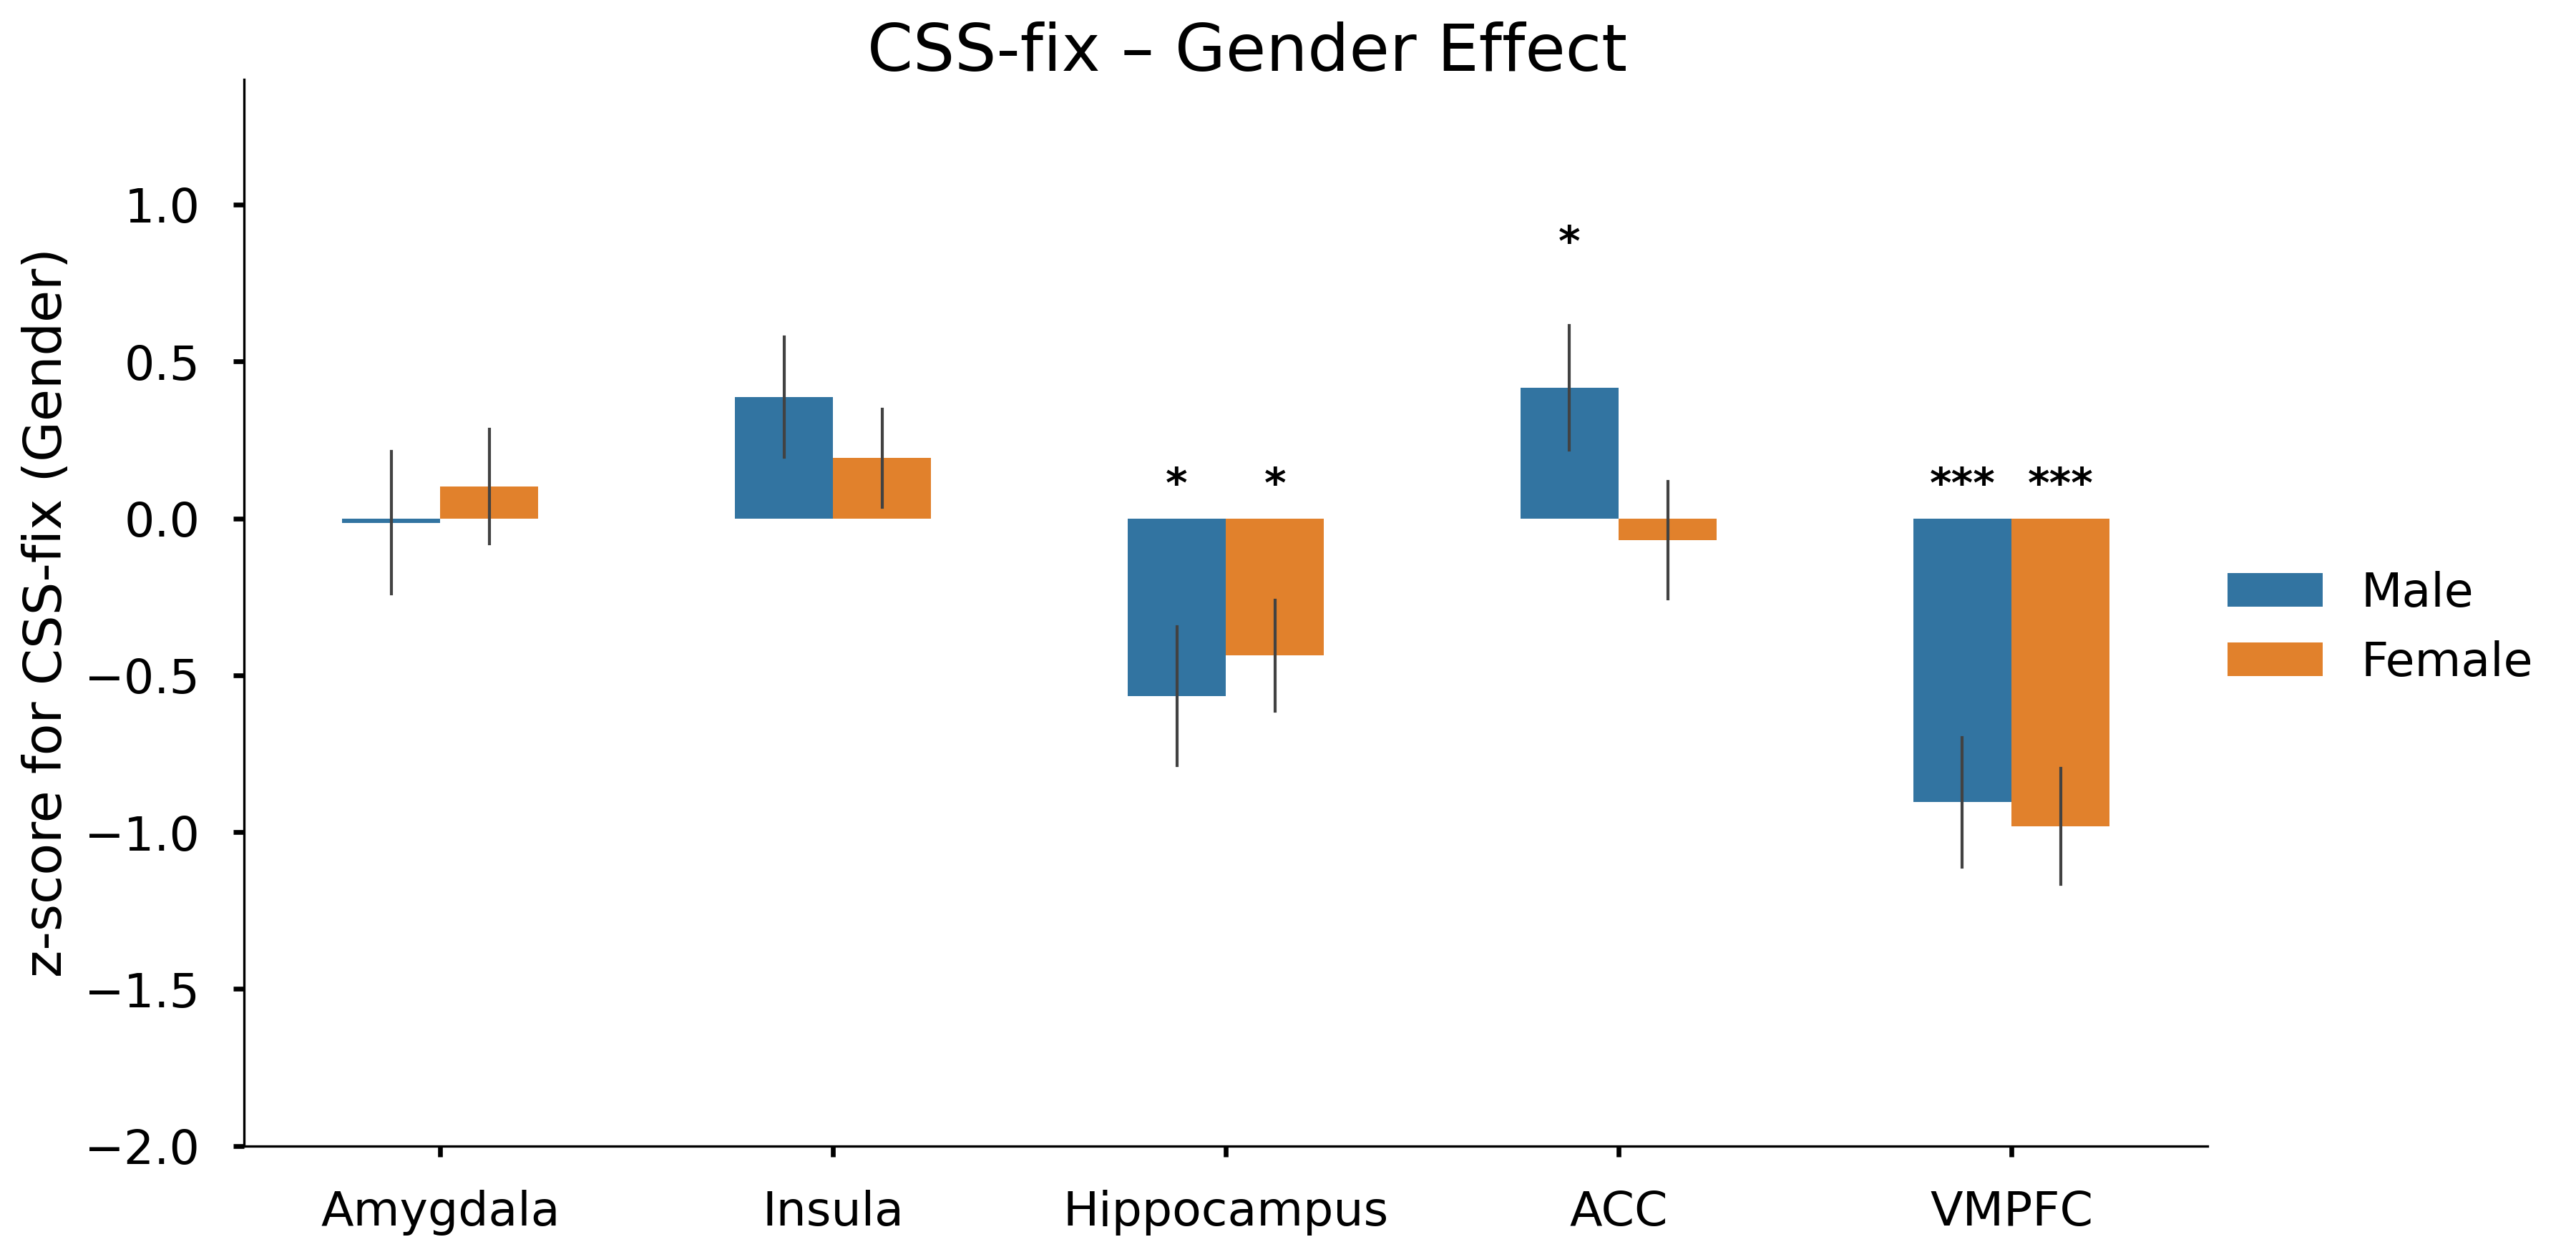


===== Gender main effect: CSminus-fix =====

Model results (Z_score ~ Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.236     0.88    99    0.383      
Insula          Gender[T.Female]                                       -0.075    -0.28    99    0.777      
Hippocampus     Gender[T.Female]                                        0.192     0.67    99    0.502      
ACC             Gender[T.Female]                                       -0.518    -2.01    99    0.047     *
VMPFC           Gender[T.Female]                                       -0.345    -1.43    99    0.157      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level               

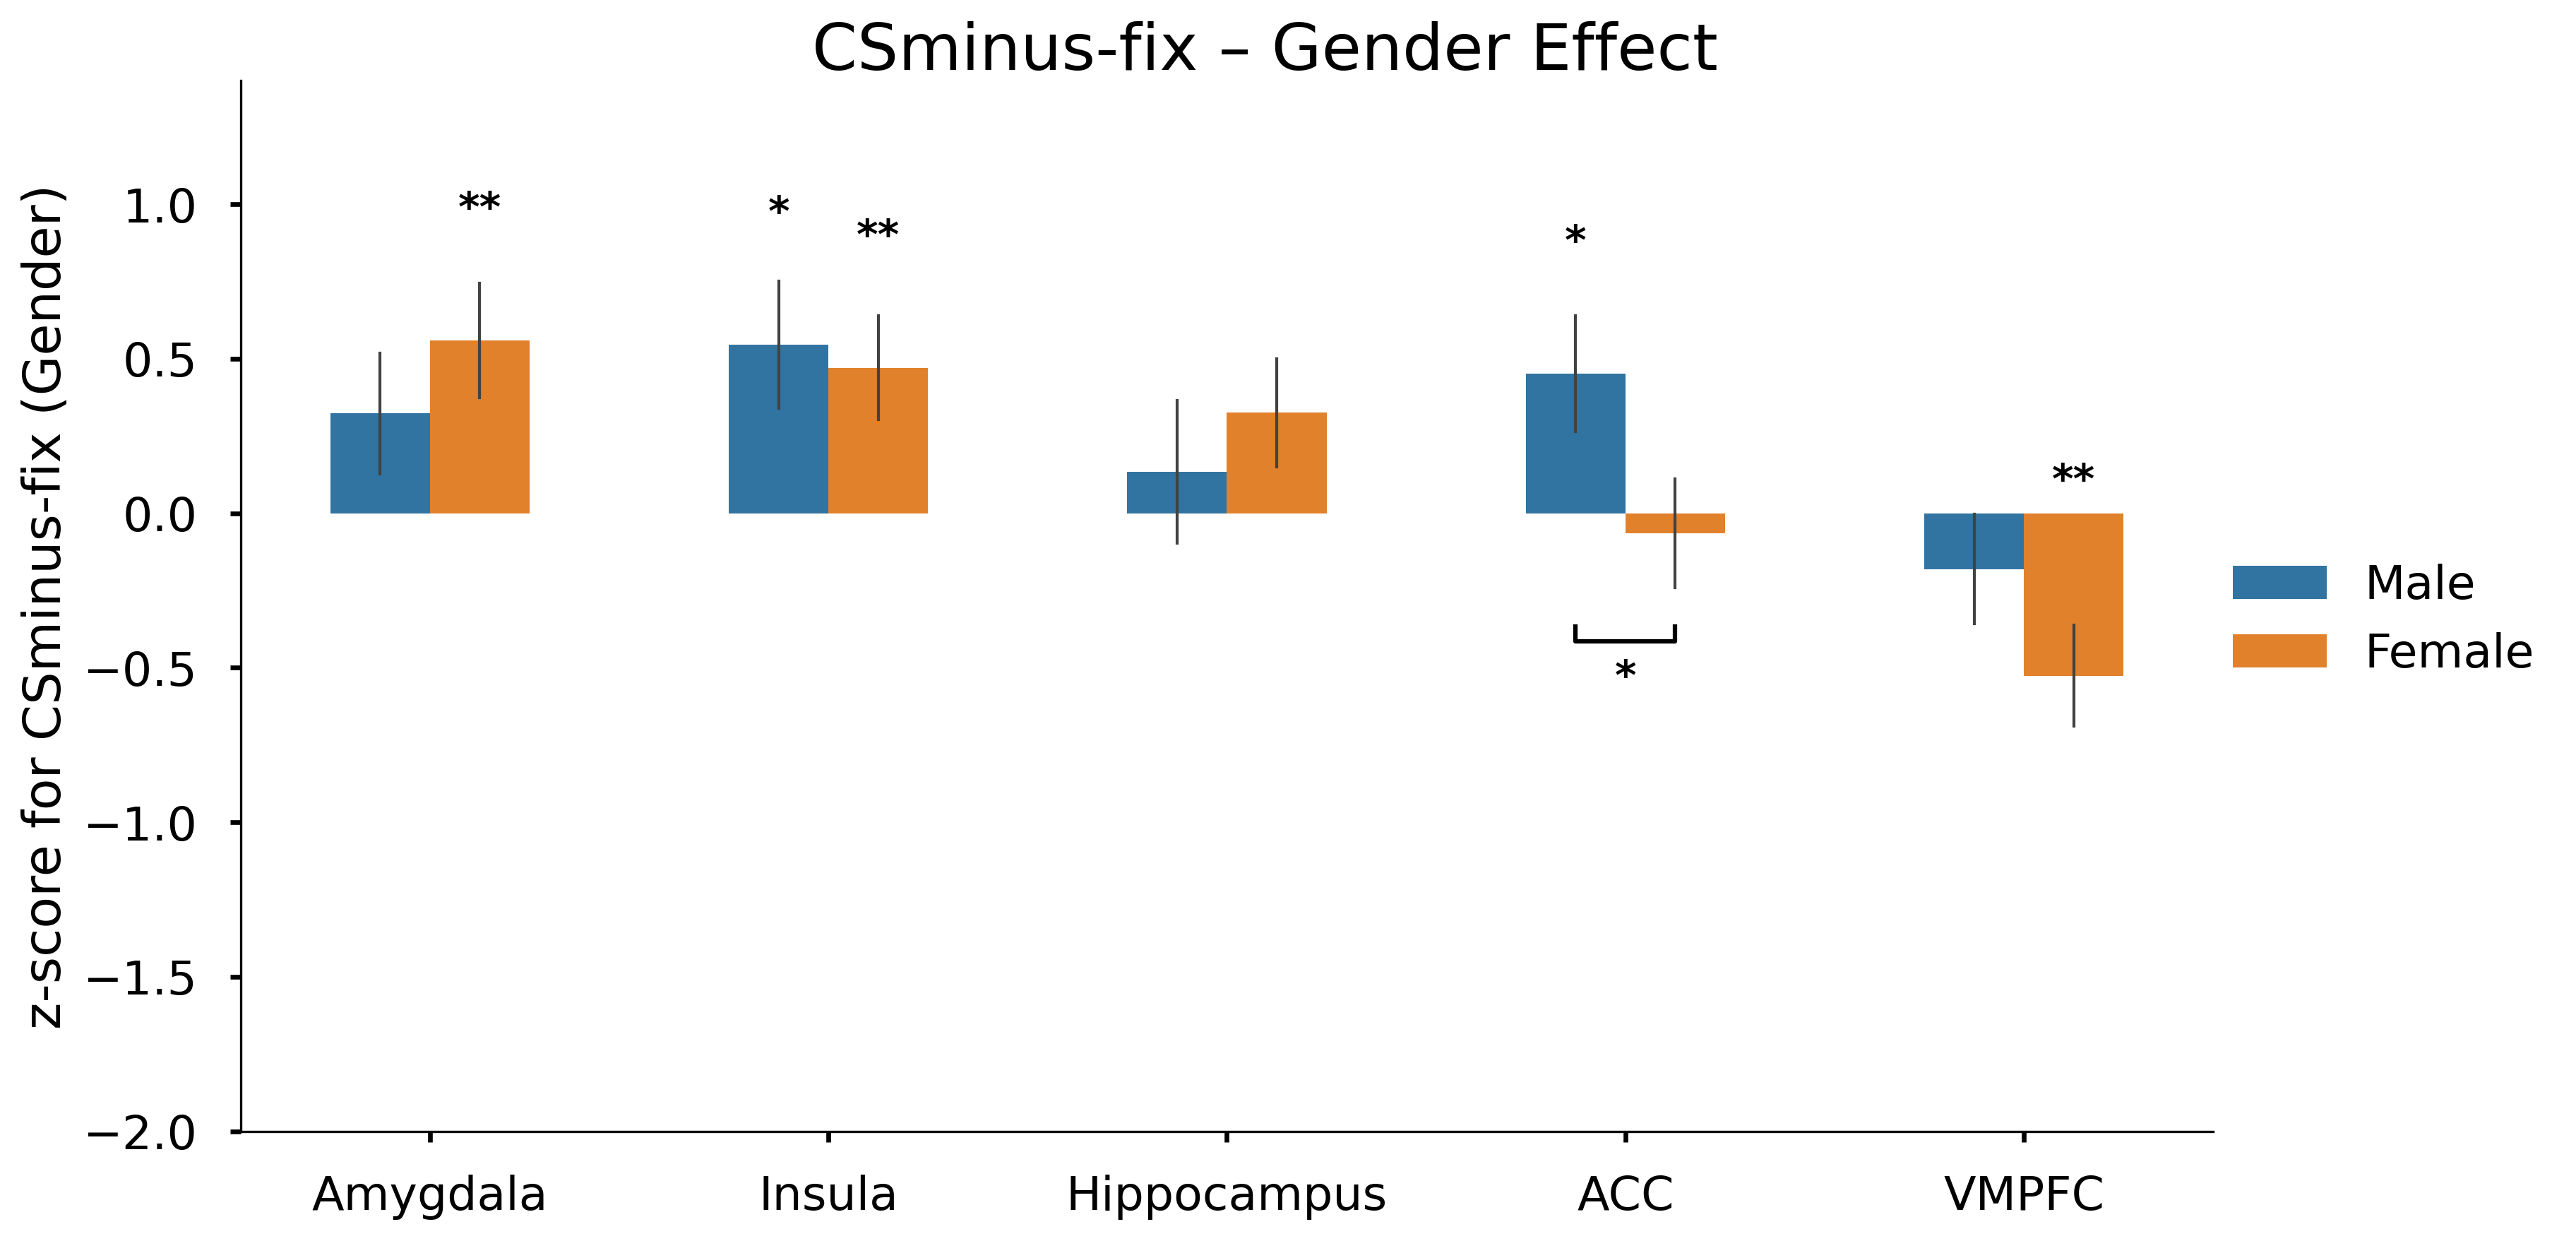

In [ ]:
# ---------------------------------------------------------
# 3️⃣ Gender main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Gender main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase3')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Gender',
        order=ROI_list, kind='bar', errorbar='se', height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Gender")[0])

    g.set_axis_labels('', f'z-score for {contrast} (Gender)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Gender Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Gender_sig.png', bbox_inches='tight')
    plt.show()


===== Group × Gender interaction: CSR-CSS =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.642     1.31    97    0.193      
Insula          Group[T.HC]:Gender[T.Female]                            0.370     0.64    97    0.524      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.585     1.15    97    0.253      
ACC             Group[T.HC]:Gender[T.Female]                           -0.077    -0.14    97    0.886      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.060     0.12    97    0.904      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

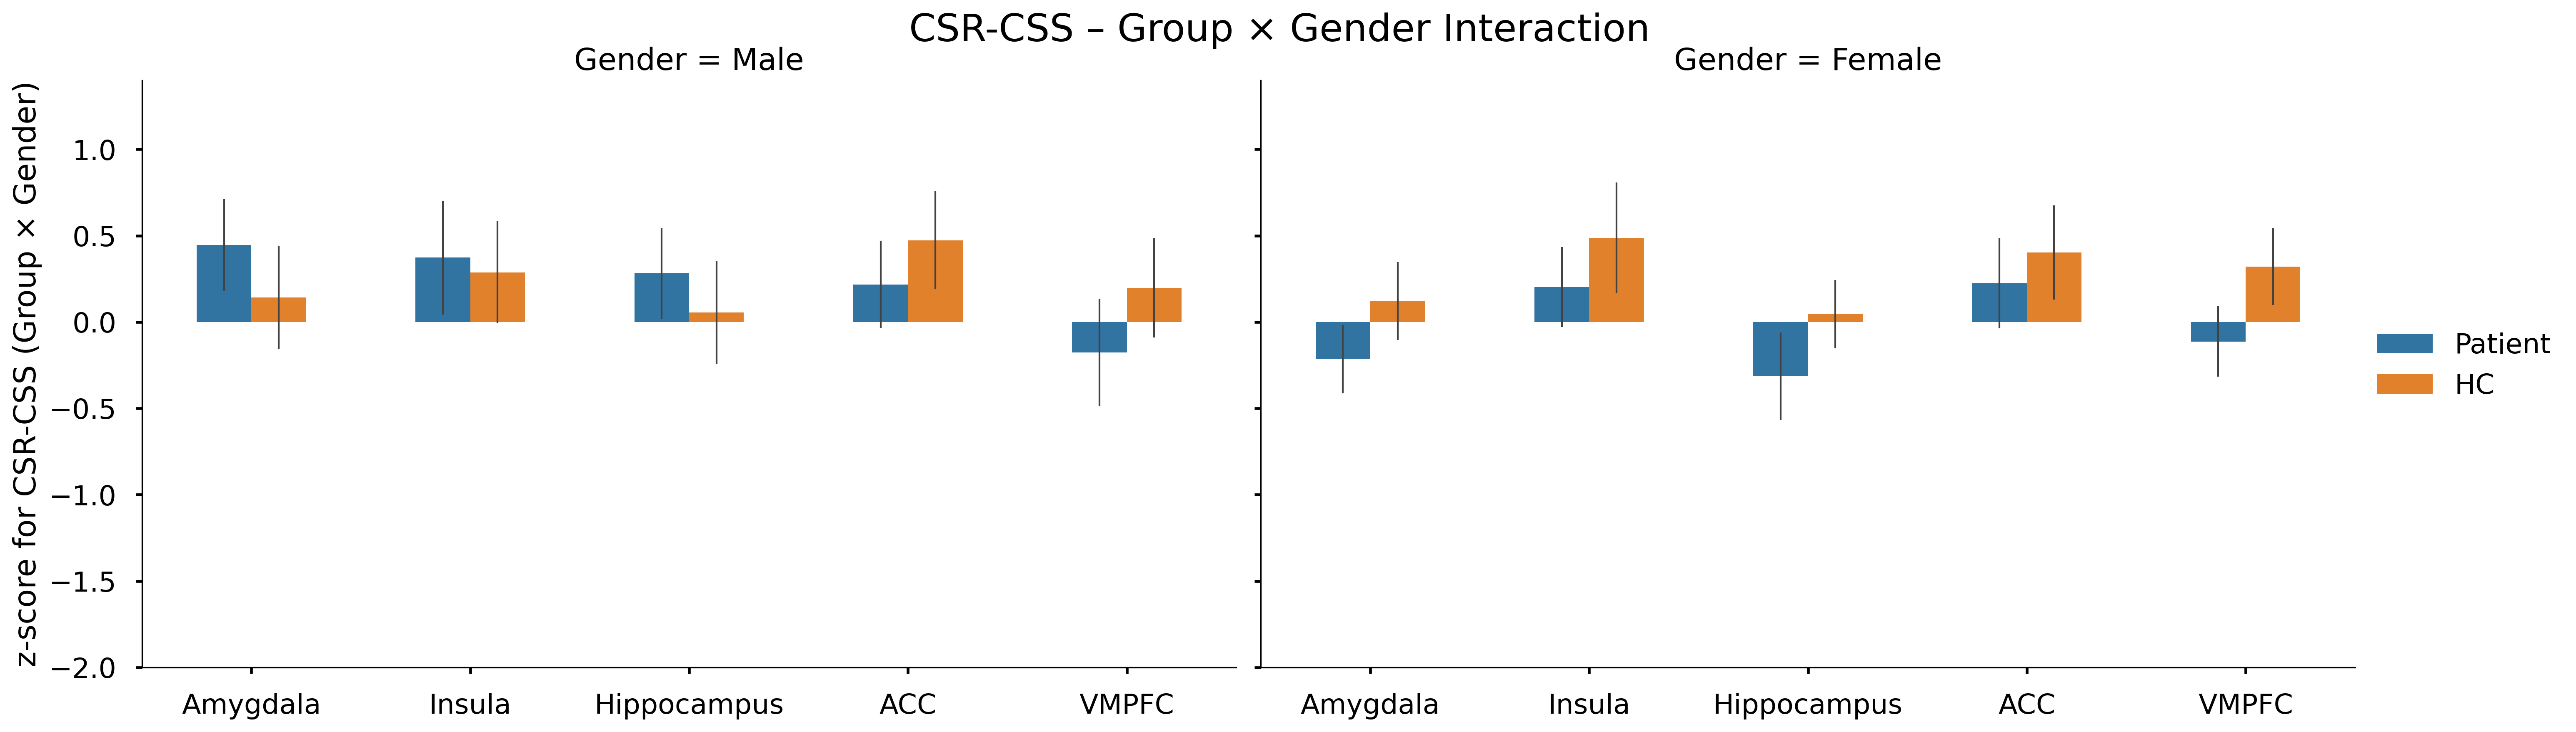


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.1933      
Insula              0.5237      
Hippocampus         0.2530      
ACC                 0.8857      
VMPFC               0.9044      
-----------------------------------


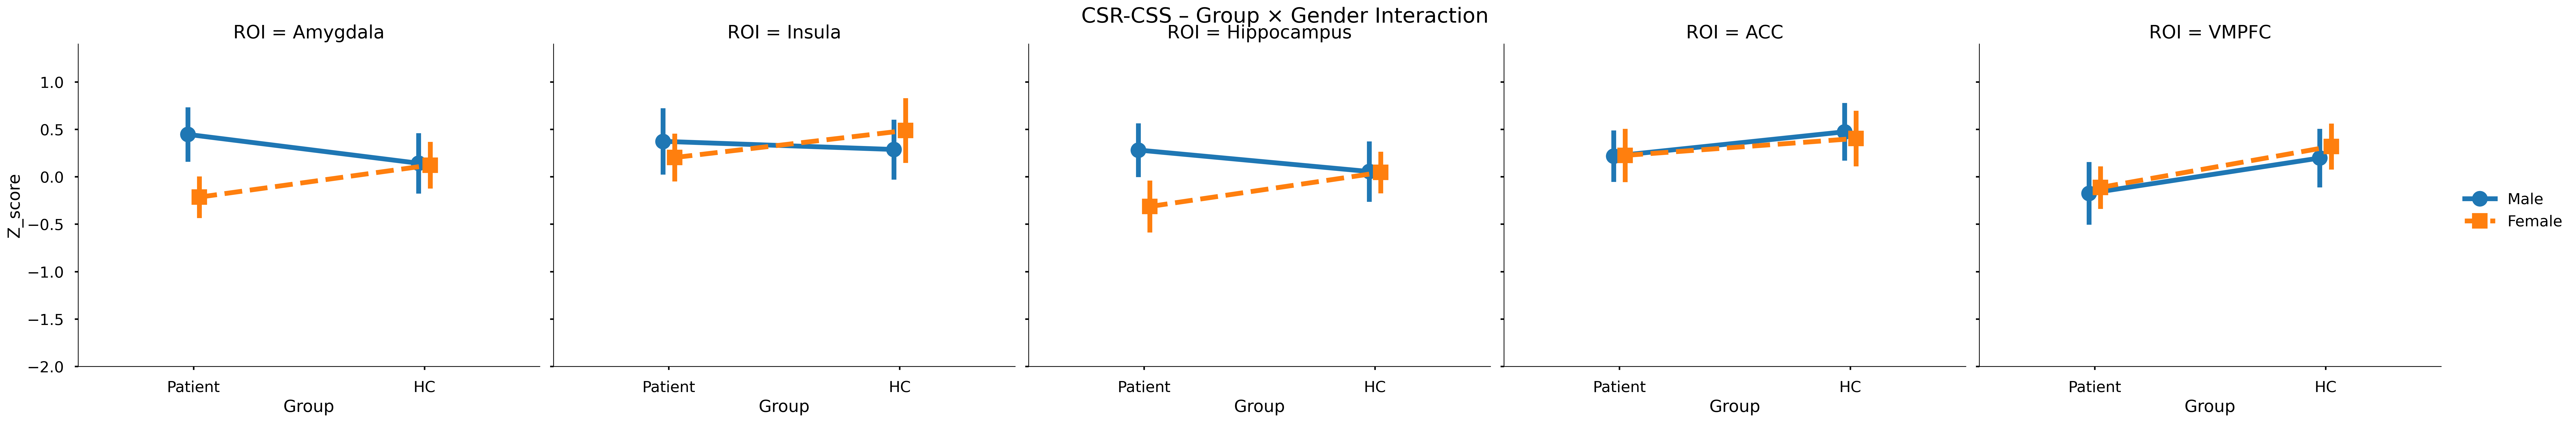


===== Group × Gender interaction: CSR-CS- =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.871     1.63    97    0.107      
Insula          Group[T.HC]:Gender[T.Female]                            0.826     1.44    97    0.152      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.743     1.38    97    0.171      
ACC             Group[T.HC]:Gender[T.Female]                            0.585     1.01    97    0.313      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.663     1.25    97    0.213      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

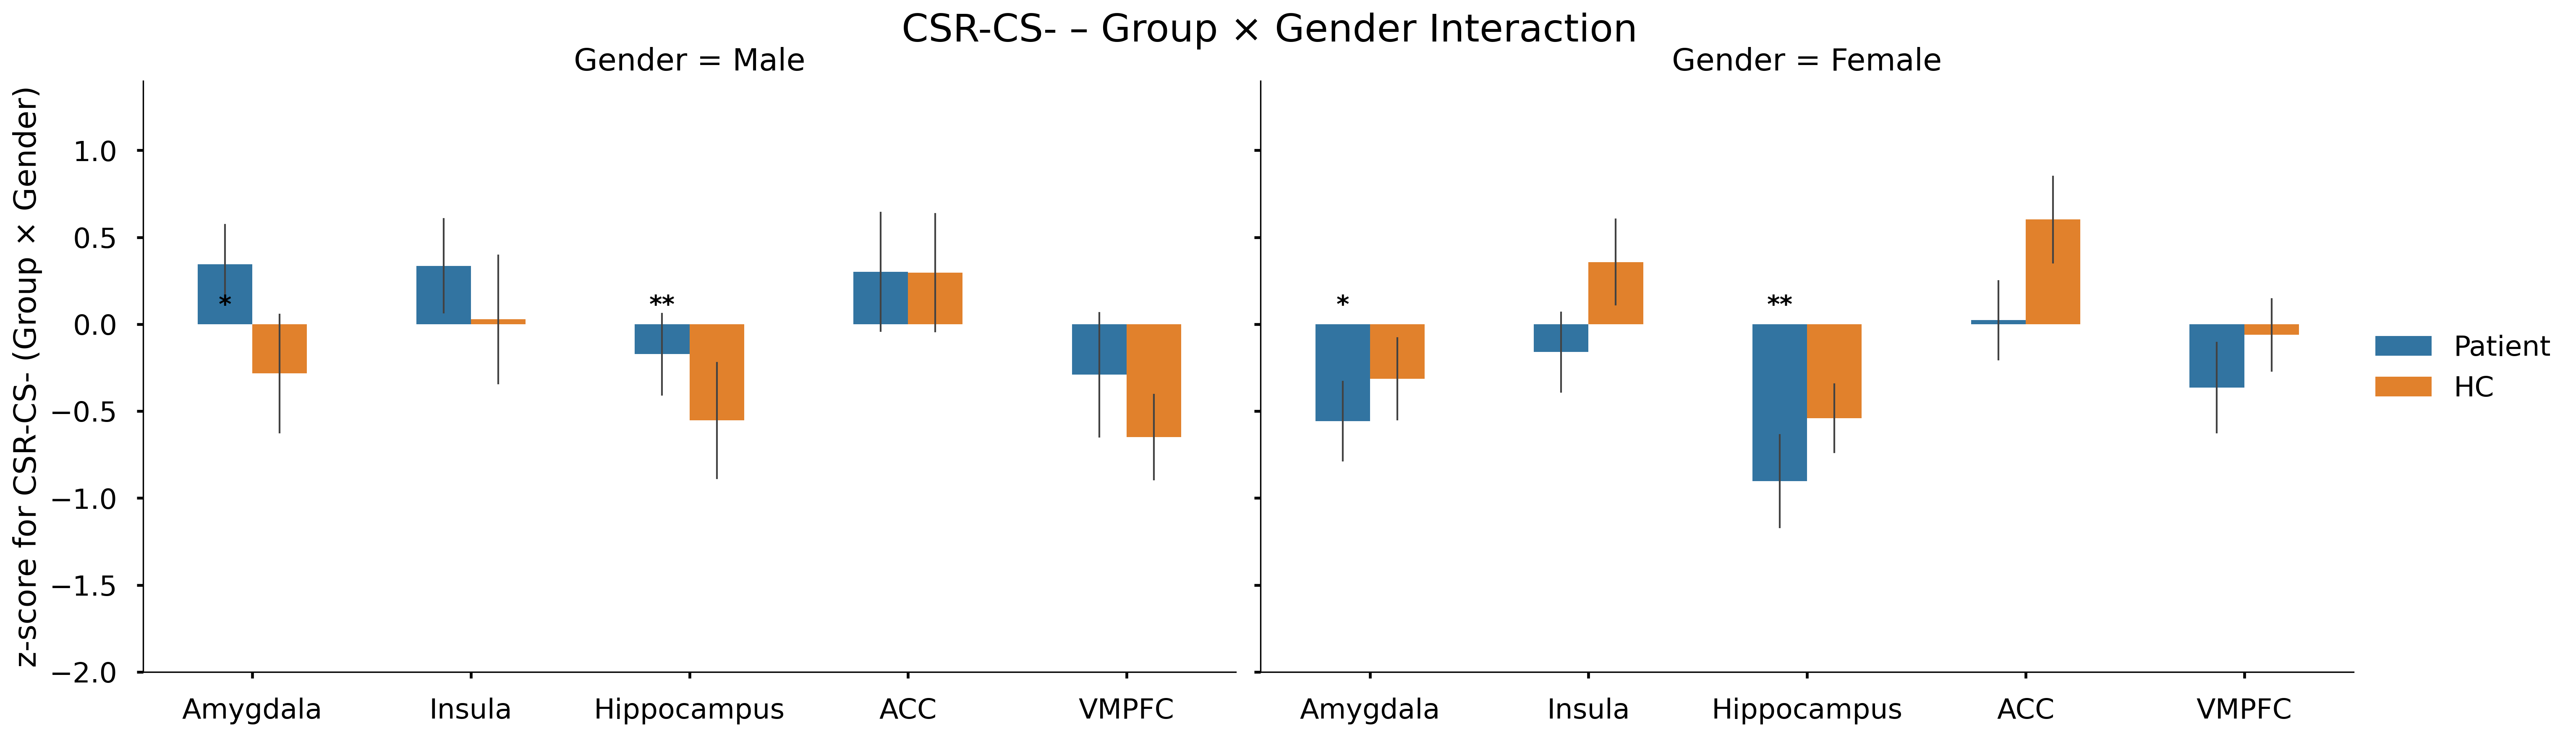


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.1066      
Insula              0.1525      
Hippocampus         0.1711      
ACC                 0.3127      
VMPFC               0.2130      
-----------------------------------


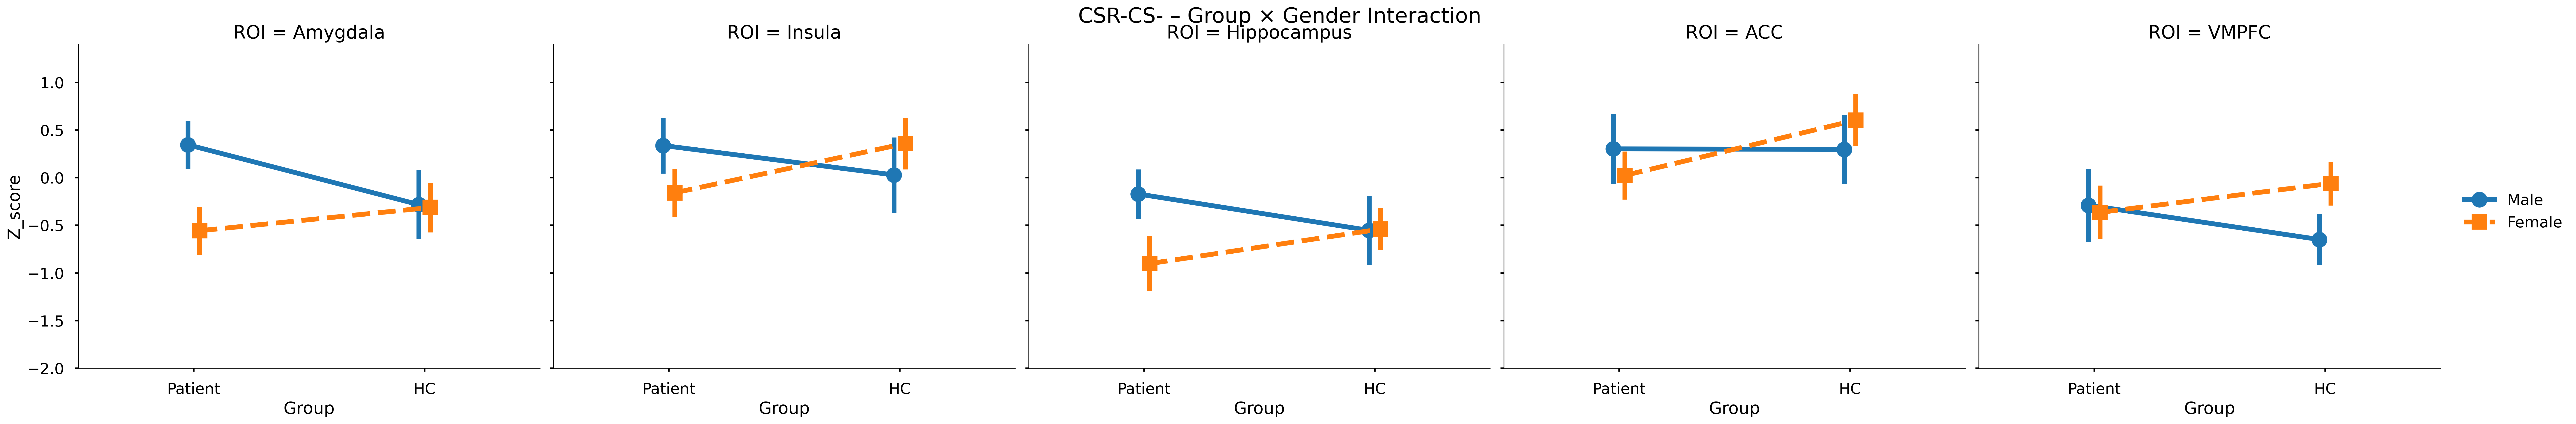


===== Group × Gender interaction: CSS-CS- =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.247     0.48    97    0.632      
Insula          Group[T.HC]:Gender[T.Female]                            0.461     0.90    97    0.368      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.160     0.31    97    0.755      
ACC             Group[T.HC]:Gender[T.Female]                            0.644     1.20    97    0.234      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.616     1.24    97    0.217      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

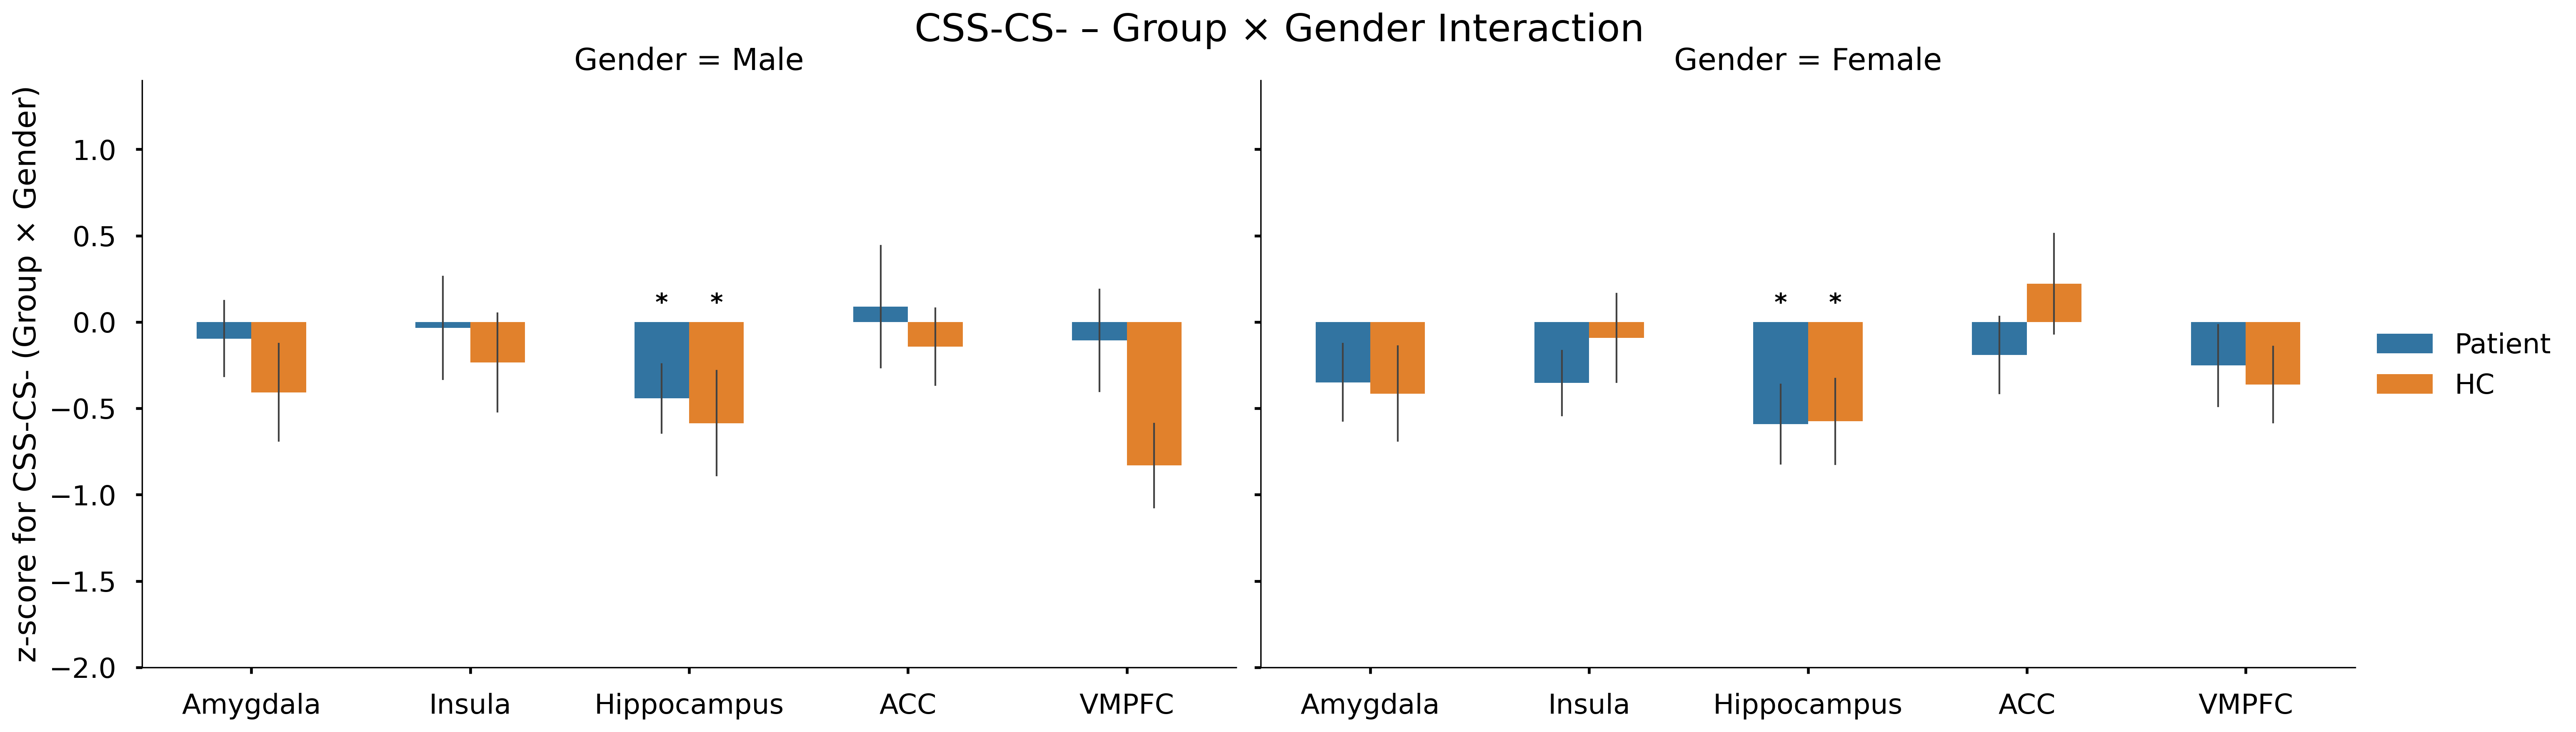


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.6321      
Insula              0.3681      
Hippocampus         0.7554      
ACC                 0.2342      
VMPFC               0.2173      
-----------------------------------


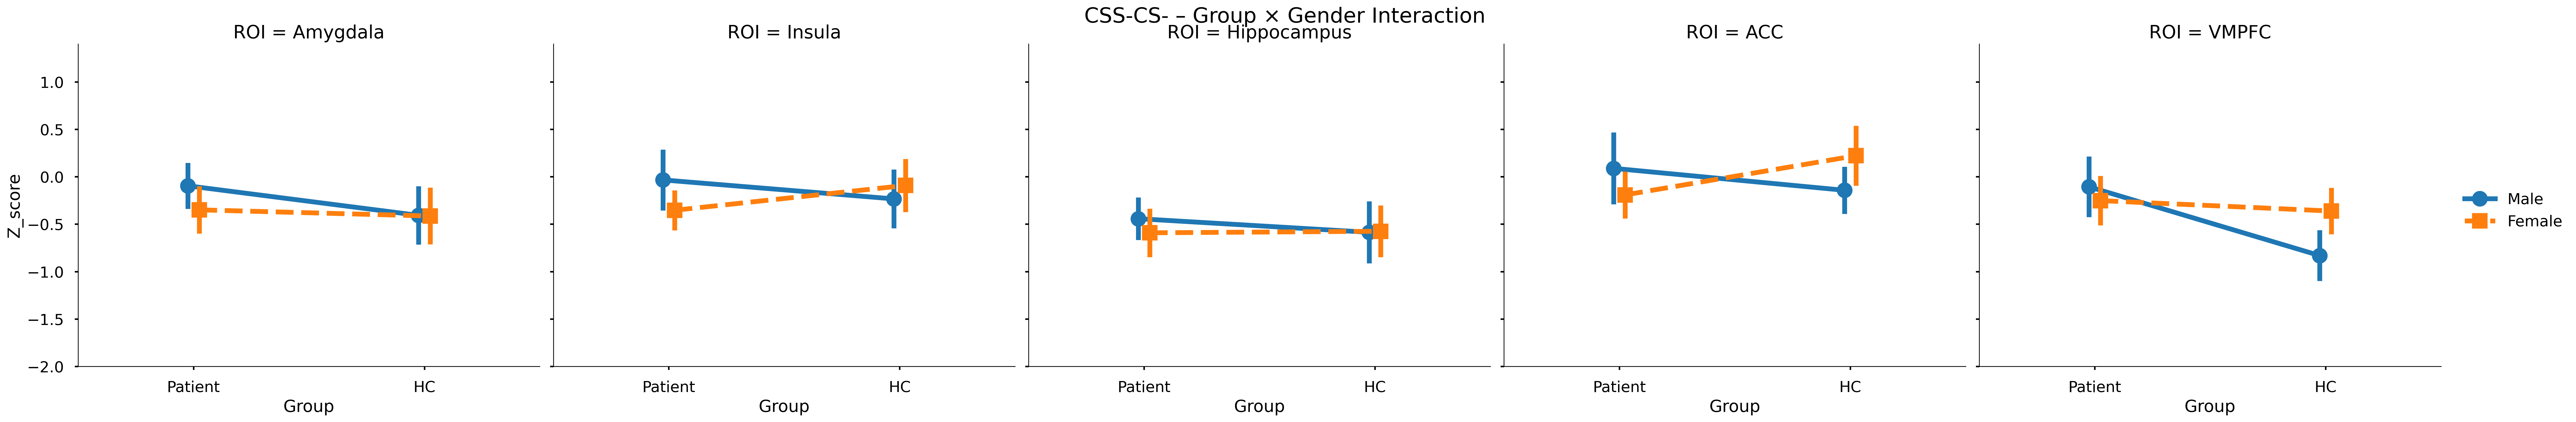


===== Group × Gender interaction: CSR-fix =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            1.259     2.05    97    0.043     *
Insula          Group[T.HC]:Gender[T.Female]                            0.893     1.36    97    0.176      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.950     1.73    97    0.086      
ACC             Group[T.HC]:Gender[T.Female]                            0.437     0.74    97    0.462      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.842     1.67    97    0.098      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

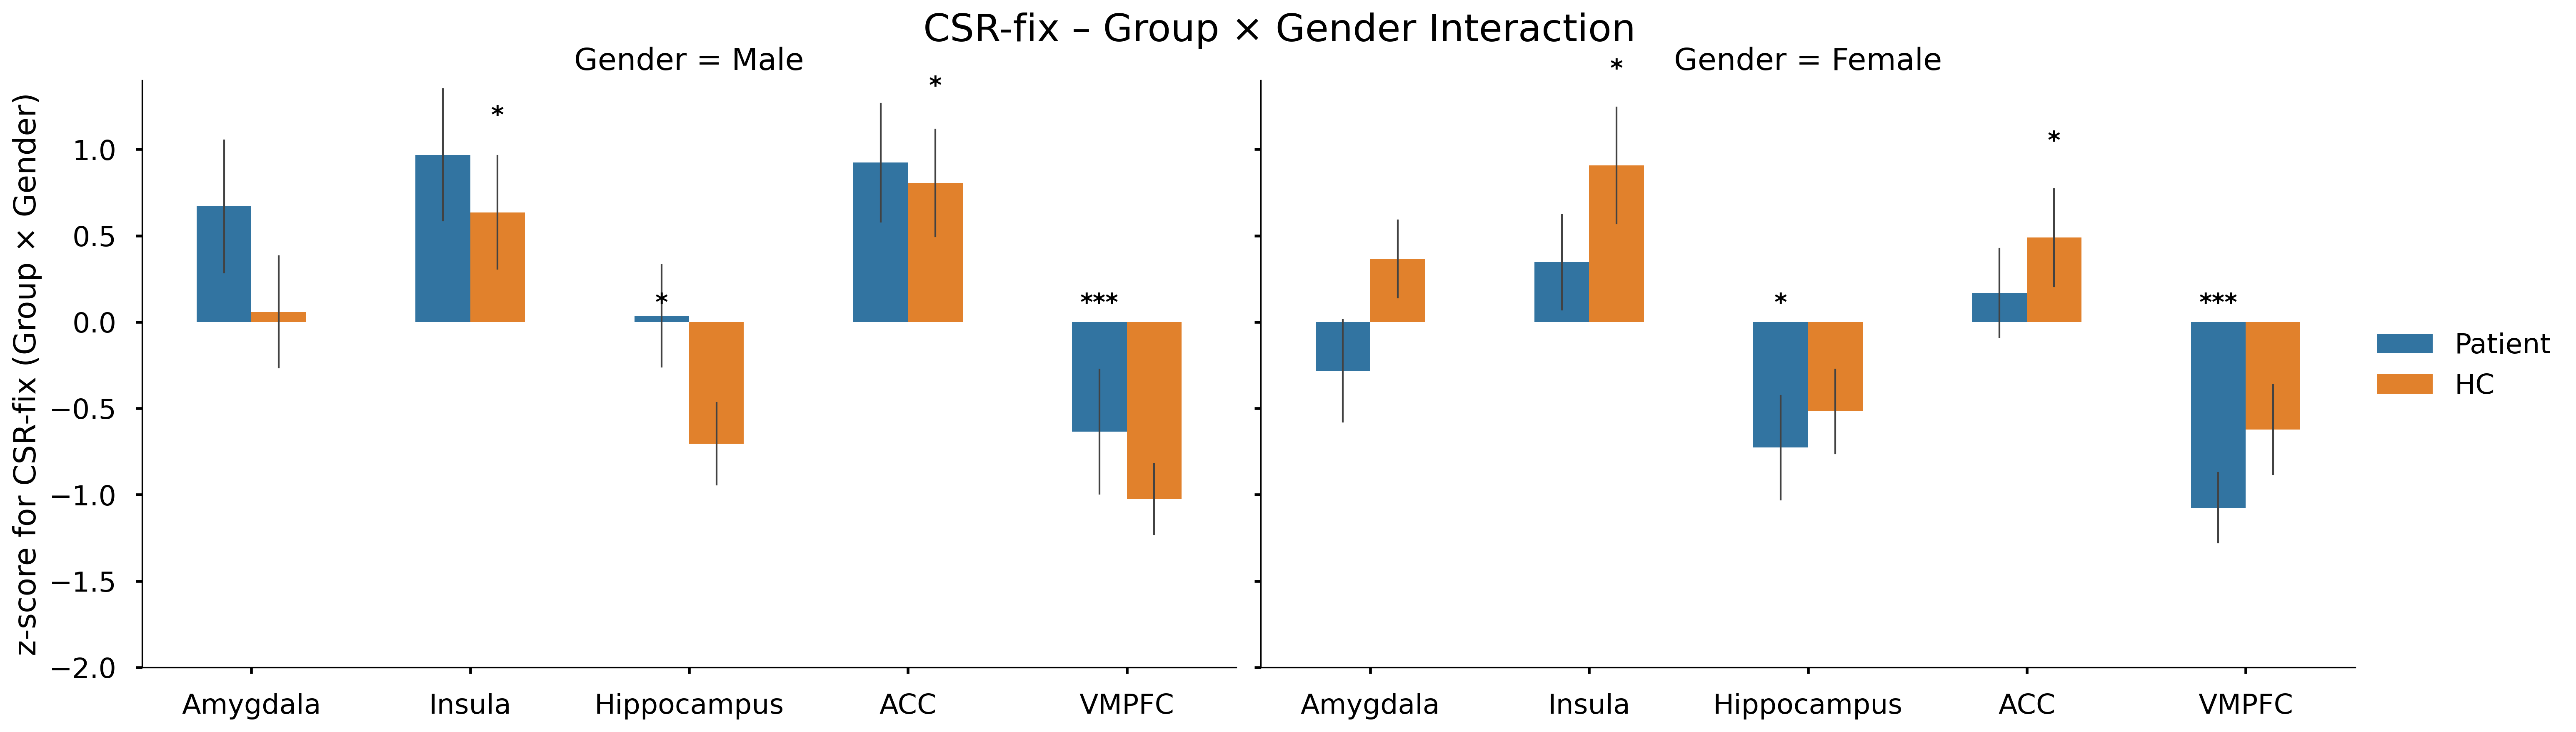


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.0428     *
Insula              0.1763      
Hippocampus         0.0860      
ACC                 0.4624      
VMPFC               0.0976      
-----------------------------------


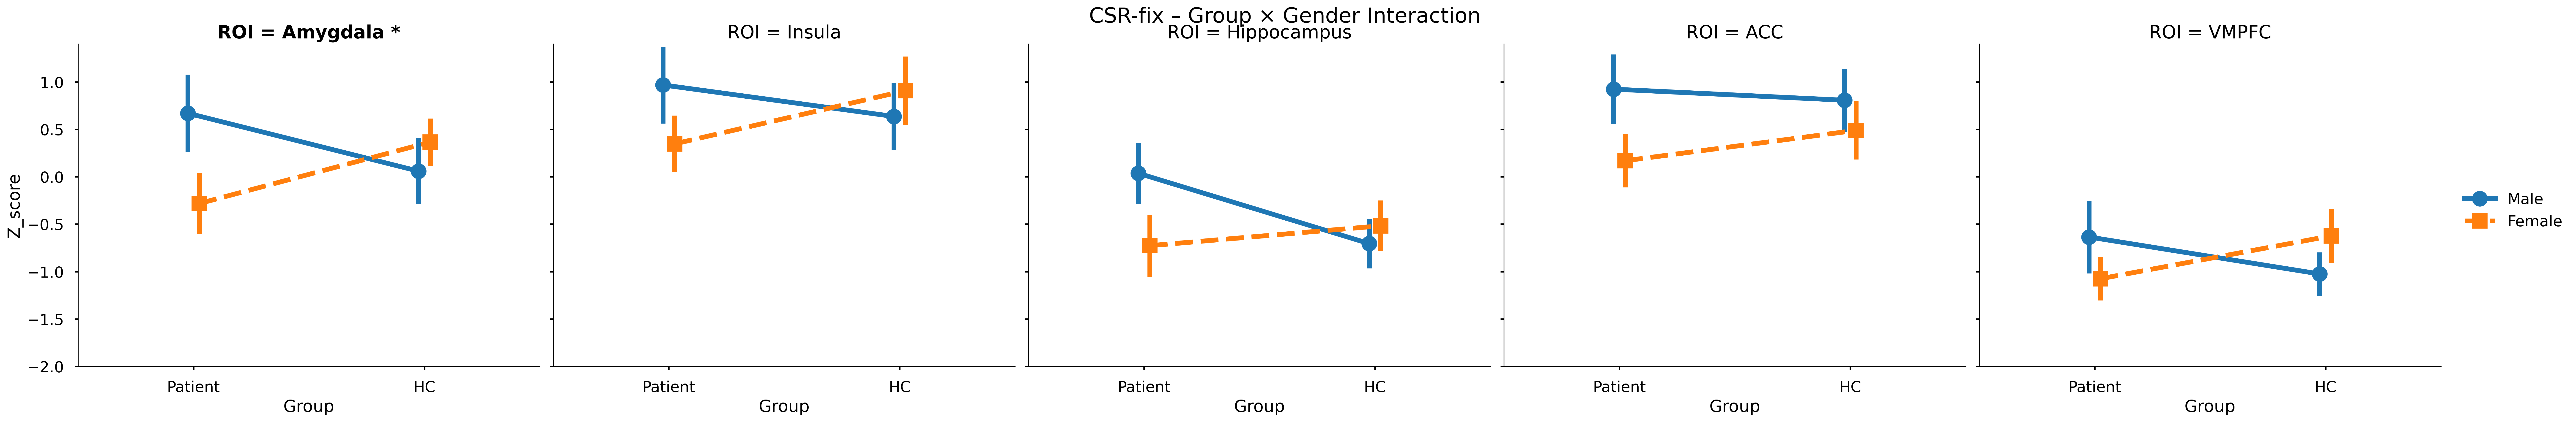


===== Group × Gender interaction: CSS-fix =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.457     0.78    97    0.435      
Insula          Group[T.HC]:Gender[T.Female]                            0.427     0.86    97    0.391      
Hippocampus     Group[T.HC]:Gender[T.Female]                            0.207     0.37    97    0.714      
ACC             Group[T.HC]:Gender[T.Female]                            0.509     0.92    97    0.360      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.757     1.38    97    0.172      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender)
RO

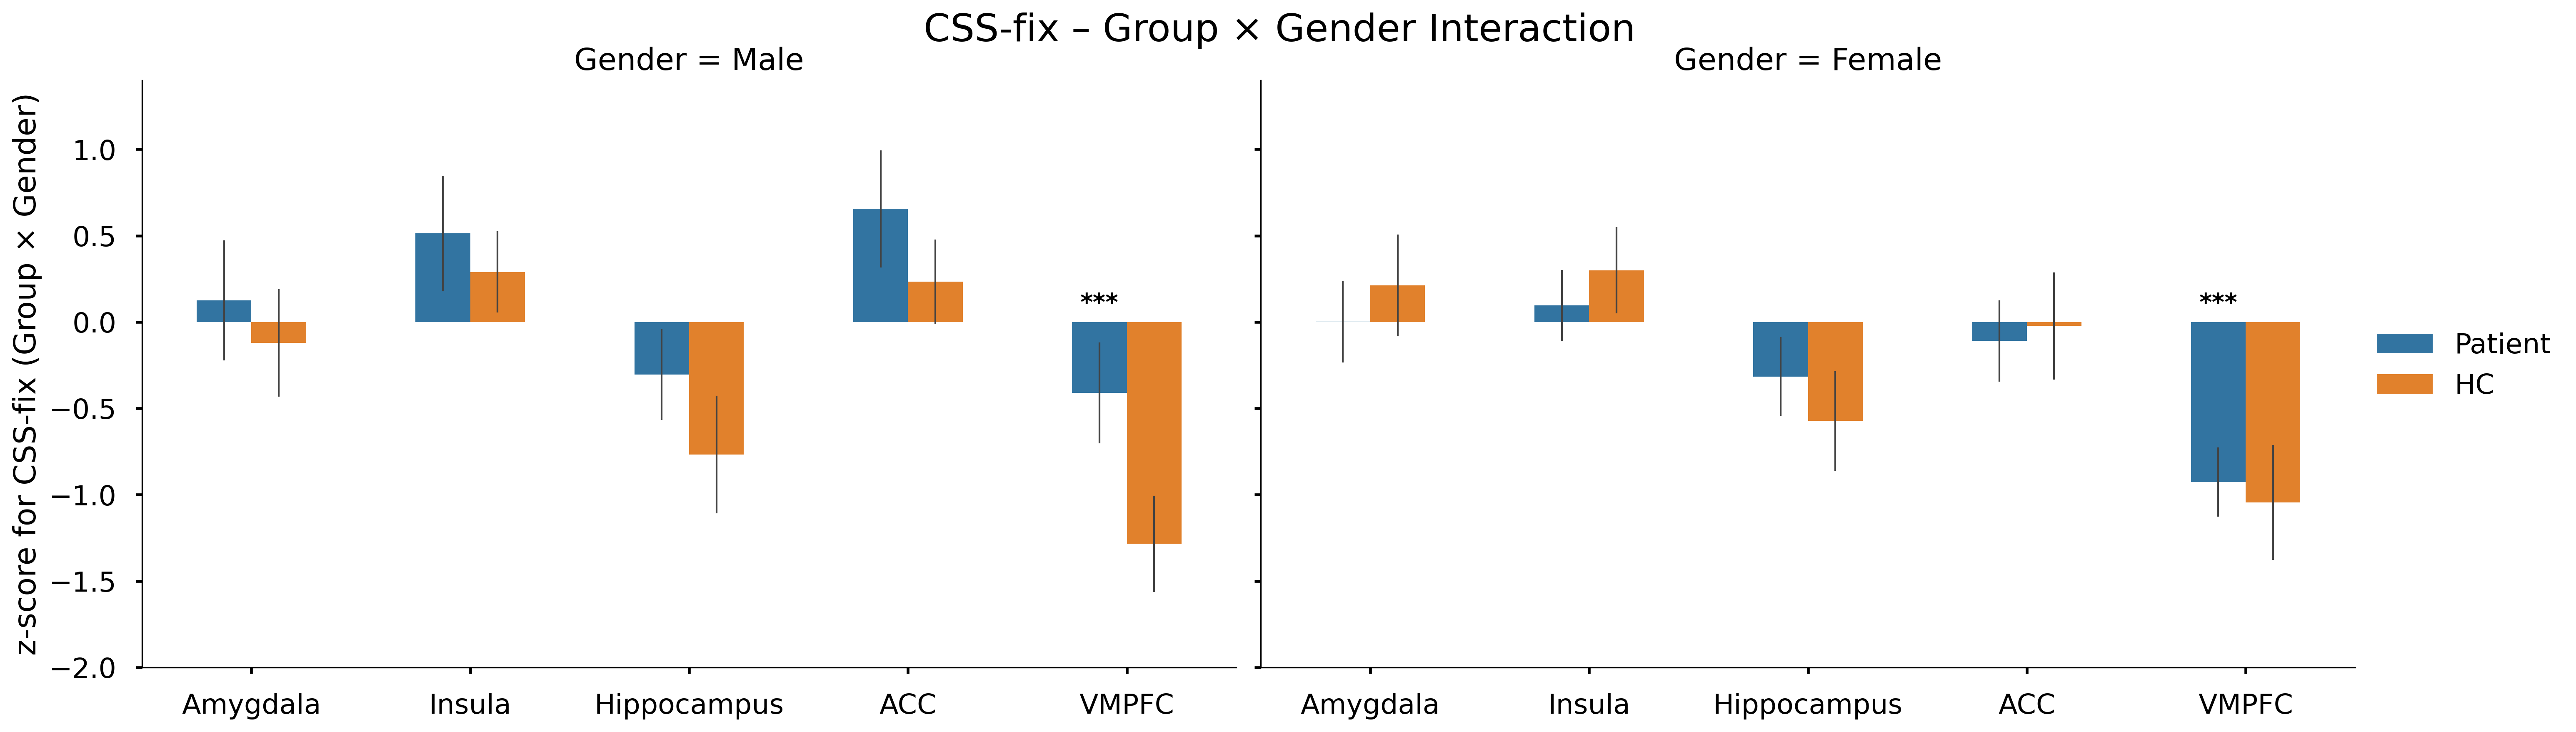


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.4348      
Insula              0.3913      
Hippocampus         0.7137      
ACC                 0.3595      
VMPFC               0.1715      
-----------------------------------


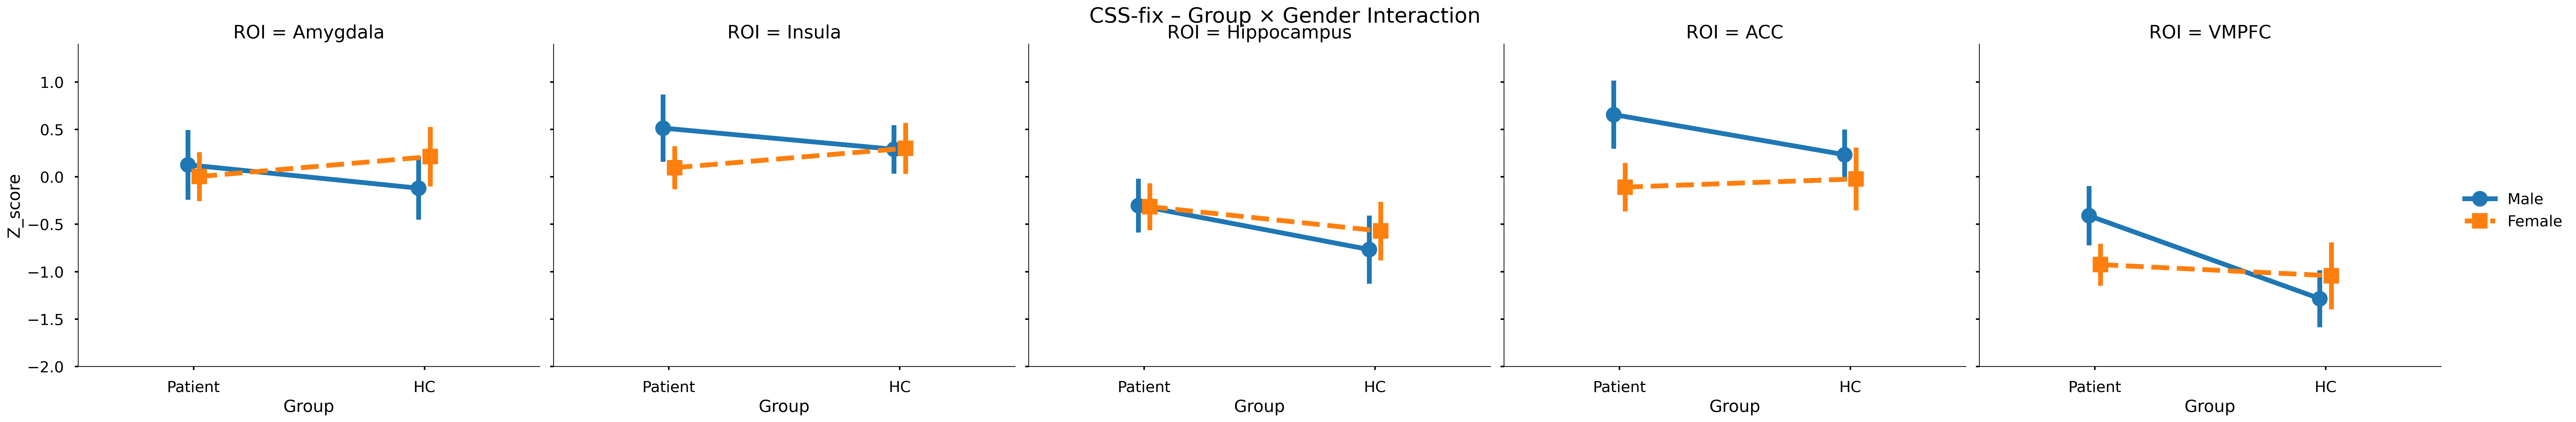


===== Group × Gender interaction: CSminus-fix =====

Model results (Z_score ~ Group * Gender)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.115     0.21    97    0.834      
Insula          Group[T.HC]:Gender[T.Female]                           -0.193    -0.36    97    0.718      
Hippocampus     Group[T.HC]:Gender[T.Female]                           -0.042    -0.07    97    0.942      
ACC             Group[T.HC]:Gender[T.Female]                           -0.327    -0.63    97    0.529      
VMPFC           Group[T.HC]:Gender[T.Female]                           -0.080    -0.16    97    0.871      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Gender

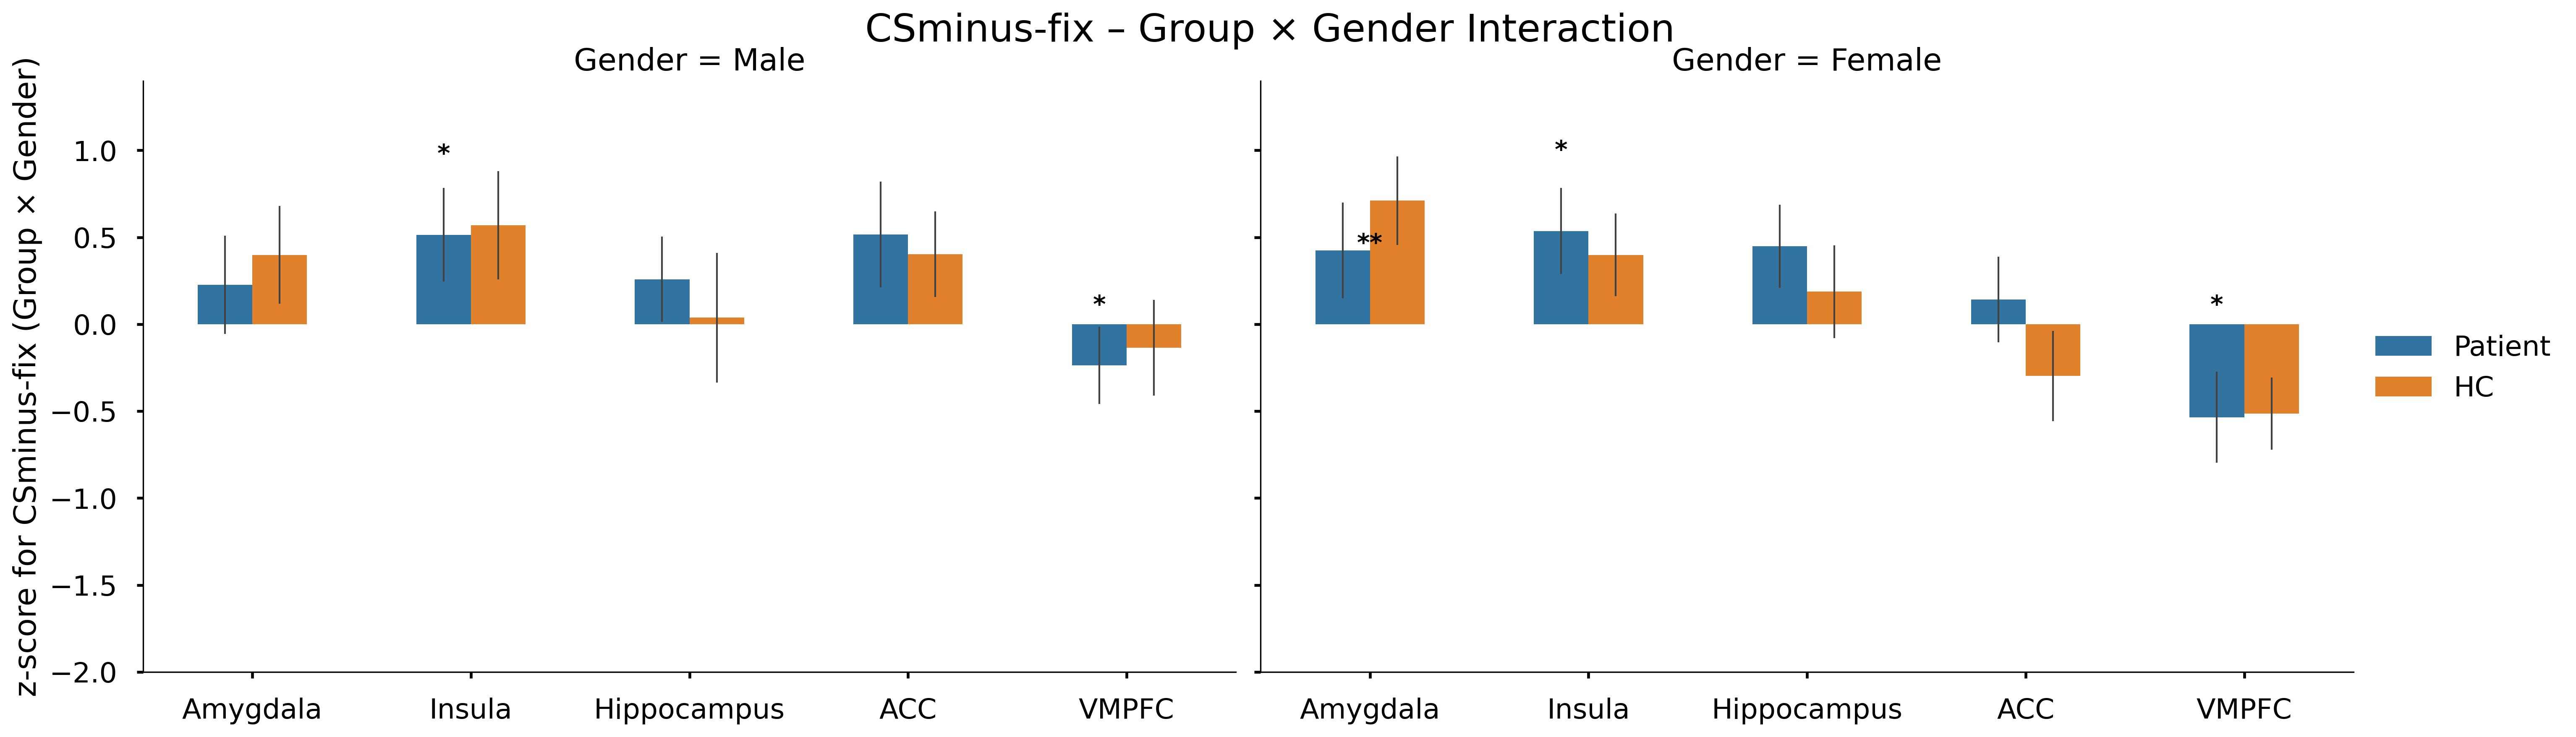


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender
ROI                p-value   Sig
-----------------------------------
Amygdala            0.8338      
Insula              0.7184      
Hippocampus         0.9422      
ACC                 0.5293      
VMPFC               0.8705      
-----------------------------------


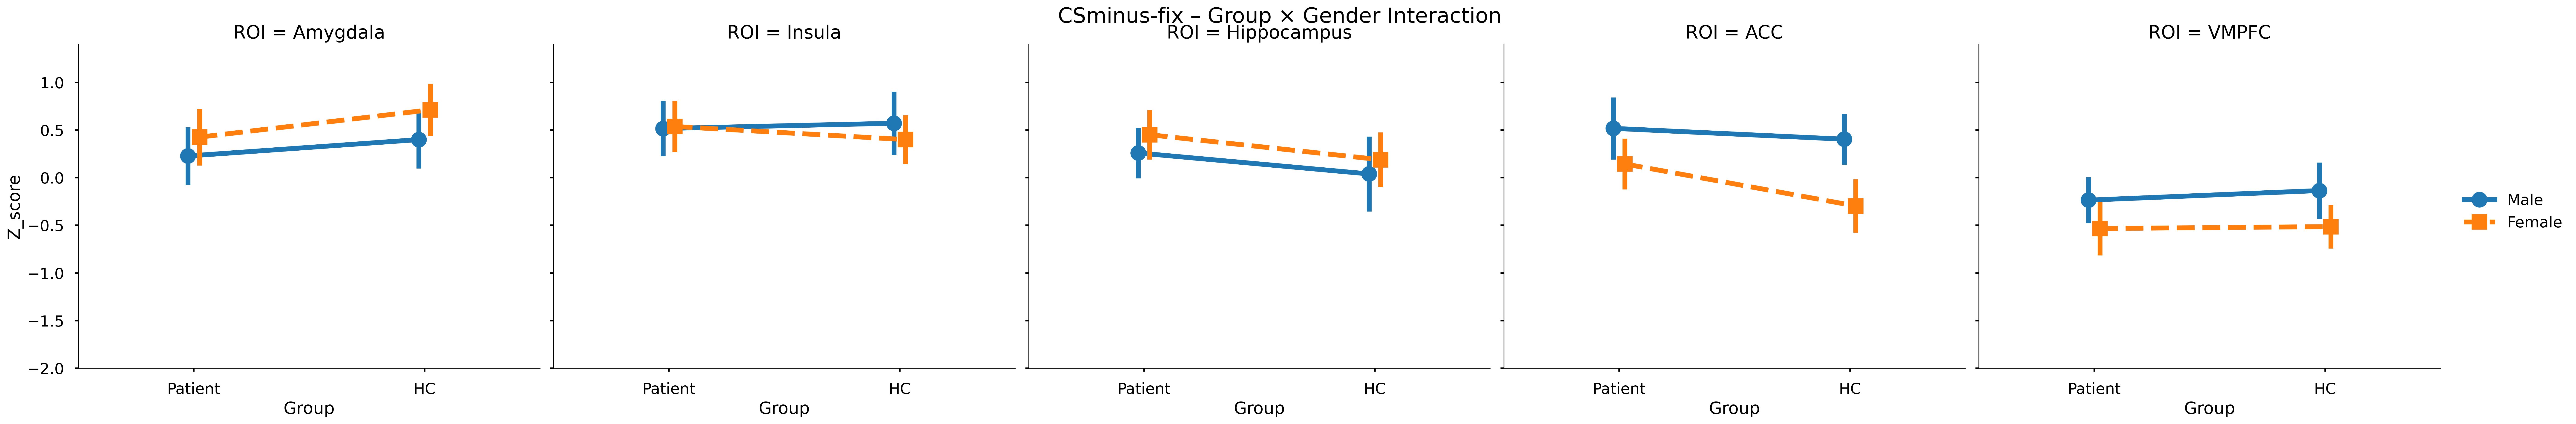

In [ ]:
interaction_terms = get_matching_model_terms(model, "two_way")

for term in interaction_terms:
    var1, var2 = extract_factors_from_term(term)
    for contrast in contrast_list:
        print(f"\n===== {var1} × {var2} interaction: {contrast} =====")
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase3')]

        g = sns.catplot(
            x='ROI', y='Z_score', hue=var1, col=var2,
            order=ROI_list,
            kind='bar', errorbar='se',
            height=6, aspect=1.6, width=0.5,
            err_kws={'linewidth': 1},
            data=df
        )

        for ax in g.axes.flat:
            add_sig_stars(ax, df, ROI_list, term)

        g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

        #line plots
        g = sns.catplot(
            data=df,
            x=var1, y='Z_score', hue=var2,
            col='ROI',
            kind='point',         # line plot (mean + SE)
            errorbar='se',        # ✅ correct for seaborn ≥0.12
            dodge=True,
            markers=['o', 's'],
            linestyles=['-', '--'],
            height=6, aspect=1.2
        )
        add_sig_stars_lineplot_interaction(
            g.axes, df, ROI_list, term
        )
        #g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/line_{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

In [ ]:

formula = "Z_score ~ Group * Gender"

for contrast in contrast_list:
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase3')]

        print(f"\nModel results ({formula}) in {contrast}")
        print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
        print("-" * 100)

        # === Table 1: Model results ===
        for i, roi in enumerate(ROI_list):
            df_roi = df[df["ROI"] == roi]
            if len(df_roi) < 4:
                continue
            model = smf.ols(formula, data=df_roi).fit()
            dfree = int(model.df_resid)

            # Extract and print all terms except intercept
            for term in model.params.index:
                if term.lower() == "intercept":
                    continue

                beta = model.params[term]
                tval = model.tvalues[term]
                pval = model.pvalues[term]
                star = significance_marker(pval)

                print(f"{roi:<15} {term:<50} {beta:>10.3f} {tval:>8.2f} "
                    f"{dfree:>5} {pval:>10.4f} {star:>5}")

        print("-" * 100)
    


Model results (Z_score ~ Group * Gender) in CSR-CSS
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.304    -0.84    97     0.4034      
Amygdala        Gender[T.Female]                                       -0.661    -1.87    97     0.0649      
Amygdala        Group[T.HC]:Gender[T.Female]                            0.642     1.31    97     0.1933      
Insula          Group[T.HC]                                            -0.086    -0.20    97     0.8419      
Insula          Gender[T.Female]                                       -0.171    -0.41    97     0.6847      
Insula          Group[T.HC]:Gender[T.Female]                            0.370     0.64    97     0.5237      
Hippocampus     Group[T.HC]                                            -0.226 